In [10]:
import random 
import matplotlib.pyplot as plt
from matplotlib import interactive
import matplotlib.patches as mpatches
import math
import numpy as np
from numpy.polynomial.polynomial import polyfit
from scipy import special
import scipy as sp
import scipy.stats

In [11]:
plt.rcParams['figure.figsize'] = [12, 6]

In [14]:
#parameters we implement throughout the analysis unless changes to them are made
c = 15
n = 1000
a = 1
p = .05
N = 1000 
m = 50

Class defining a paper in the citation network

In [4]:
#citation network class
class node():
    def __init__(self):
        self.inDegree = 0
        self.inDegList = []
        self.outDegList = []
    def increment(self, x):
        self.inDegree += x
    def listAdd(self):
        self.inDegList.append(self.inDegree)
    def outDegAdd(self, y):
        self.outDegList.append(y)

This function is used to create the network using the approach where a citation is made by the node list with $1-p = \frac{a}{c+a}$ and by the sampling list with $p=\frac{c}{c+a}$

In [15]:
#method for constructing the citation network
#Implement Prices model using the breakdown of the citation probability
def createNetworkSamplingWithRep(c, a, n):#this is the one we use, when c is deterministic 
    network = []
    samplingList = []
    nodeList = []
    prob = c/float(c+a)
    for i in range(1, n+1):
        newPaper = node()
        network.append(newPaper)
        tempList = []
        if i != 1:
            for j in range(0, c): #make all c citations 
                if samplingList: #make sure sampling list is non-empty
                    if random.uniform(0,1) <= prob: 
                        s = random.choice(samplingList) #choose from samplingList uniformly, preferential attachment
                        tempList.append(s)
                        network[i-1].outDegAdd(s)
                        network[s-1].increment(1)
                        #network[s-1].listAdd()
                    else:
                        k = random.choice(nodeList) #else sample from the node list
                        tempList.append(k)
                        network[i-1].outDegAdd(k)
                        network[k-1].increment(1)
                else:
                    k = random.choice(nodeList)
                    tempList.append(k)
                    network[i-1].outDegAdd(k)
                    network[k-1].increment(1)
                    #network[k-1].listAdd()
            samplingList.extend(tempList)

        for j in range(0, i):
            network[j].listAdd()
        nodeList.append(i)

    return network

This function generates a random sample of a fixed size from all the papers in the network. This is a simulation of an authors publications within a network 

In [6]:
#this is the depreciated way to get the papers an author makes
def generateRandList(n, p):
    a = range(1, n + 1)
    newArray = []
    for i in range(0, len(a)):
        randUni = random.uniform(0, 1)
        if randUni <= p:
            newArray.append(a[i])
    return newArray

In [7]:
#this is the easier and less convoluted way to do this
#use this to collect the m papers which define a "synthetic" author
def generateRandList_uni(n, m):
    return np.random.choice(n, m)

In [16]:
#will plot the citation count of all an "author's" papers as more and more papers are added
def plotNetwork(aNetwork, randomList): #plots
    length = len(aNetwork)
    xAxis  = range(1, length+1)
    for i in randomList:
        plt.plot(xAxis[i-1:], aNetwork[i-1].inDegList) 
    plt.xlabel('Paper Number')
    plt.ylabel('Citations')
    #plt.title('One Authors Papers in the Network')
    plt.savefig('Synthetic_one_aut')
    plt.show()


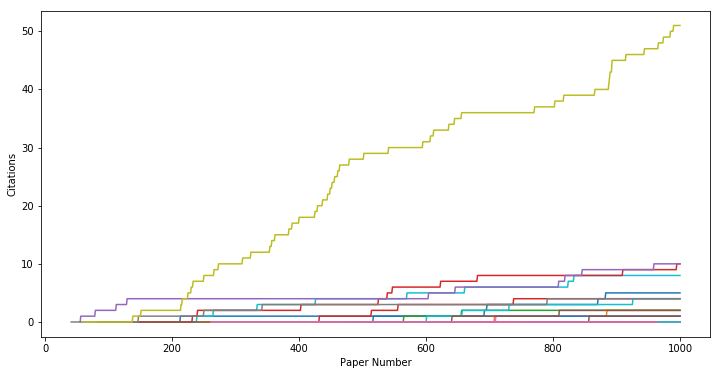

In [17]:
first_network = createNetworkSamplingWithRep(c, a, n)
rList = generateRandList(n, p)
m=30
rList = generateRandList_uni(n, m)
plotNetwork(first_network, rList)

Now we must look towards demonstrating the validity of our expected value model

This function averages $100$ networks to find the show what the average network might look like

In [25]:
#this function creates a number of citation networks
#then takes the average citation count for each jth paper
#plotting functionality included
#plots the average citation network citation growth for a paper you choose --- paperNum
def generateAvg(c, a, n, code, num, paperNum):
    networkList =[]
    if code == 'none':
        for i in range(0, num):
            networkList.append(createNetworkSamplingWithRep(c, a, n))
    else:
        for i in range(0, num):
            networkList.append(createNetworkSamplingWithRepDist(c, a, n, code, 30))
    for i in range(0, num):
        plotNetworkNew(networkList[i], [paperNum], 'red')


    avgNodeList = []

    m = n
    for i in range(0, n):
        avgPaper = node()
        avgNodeList.append(avgPaper)		
        for j in range(0, m):
            x = 0
            for k in range(0, num):
                #print networkList[k][i].inDegList[j]
                if j == 0:
                    x += networkList[k][i].inDegList[j]
                else:
                    x += (networkList[k][i].inDegList[j]-networkList[k][i].inDegList[j-1])

            y = x/float(num)
            #print y
            avgNodeList[i].increment(y)
            #print avgNodeList[i].inDegree
            avgNodeList[i].listAdd()
        m -= 1
    plotNetworkNew(avgNodeList, [paperNum], 'blue')
    red_patch = mpatches.Patch(color='red', label='Simulated Paper Network')
    blue_patch = mpatches.Patch(color='blue', label='Average of Simulated Data')
    plt.legend(handles=[red_patch, blue_patch])
    plt.xlabel('Paper Number')
    plt.ylabel('Citations')
    plt.title('Paper %i' % paperNum)
    plt.show()
    return avgNodeList

In [26]:
def plotNetworkNew(aNetwork, randomList, colored): #plots
    length = len(aNetwork)
    xAxis  = range(1, length+1)
    for i in randomList:
        plt.plot(xAxis[i-1:], aNetwork[i-1].inDegList, color = colored)

This function is for finding the theoretical expected value for citations made to the $j^{th}$ paper

In [27]:
#this is for creating a network where the citation count is actually the theoretical ev
def expectedVal3(c, a, n, paperNum):#generalizes for citations made to the jth paper
    arrayValue = []
    b = c/float(c+a)
    e1 = (a*b)/float(paperNum)
    for i in range(0,n-paperNum+1):
        if i == 0:
            arrayValue.append(0)
        elif i == 1:
            if paperNum == 1:
                arrayValue.append(c)
            else:
                arrayValue.append(e1)
        else:
            ev = a*b*(1/float(i-1+paperNum)) + (1 + b*(1/float(i-1+paperNum-1)))*arrayValue[i-1] #a little formula for finding it
            arrayValue.append(ev)
    return arrayValue

In [28]:
#makes the Expected Value network
def buildEVnetwork(c, a, n):
    net = []
    for i in range(1, n+1):
        net.append(expectedVal3(c, a, n, i))
    return net

In [29]:
def plotNetworkNew2(aNetwork, randomList, colored, array):#array EV and network
    length = len(aNetwork)
    xAxis  = range(1, length+1)

    red_patch = mpatches.Patch(color='red', label='Expected Value')
    blue_patch = mpatches.Patch(color='blue', label='Average of Simulated Data with 100 Networks')
    for i in randomList:
        plt.plot(xAxis[i-1:], aNetwork[i-1].inDegList, color = colored)
        plt.plot(xAxis[i-1:], array, color = 'red')
    plt.legend(handles=[red_patch, blue_patch])
    plt.show()

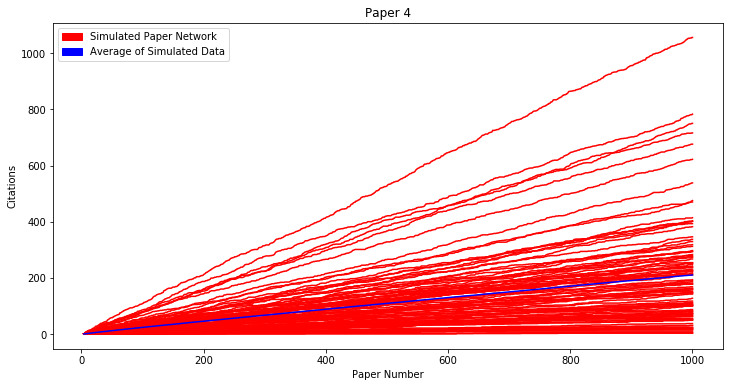

In [23]:
avg_network = generateAvg(c, a, n, 'none', 100, 4)

In [30]:
#plots the Expected number of citations and average number of citations for the jth paper as more papers are added
def plotBoth2(aNetwork, bNetwork, ithPos, randomList, tru): #takes array value as well for EV
    if tru:
        i = randomList[ithPos-1]
    else:
        i = ithPos
    length = len(aNetwork)
    xAxis = range(1, length+1)
    red_patch = mpatches.Patch(color='red', label='Expected Value')
    blue_patch = mpatches.Patch(color='blue', label='Average of Simulated Data with 100 Networks')
    
    plt.plot(xAxis[i-1:], aNetwork[i-1].inDegList, color = 'blue')
    plt.plot(xAxis[i-1:], bNetwork[i-1], color = 'red')
    plt.xlabel('Paper Number')
    plt.ylabel('Citations')
    plt.title('%ith Paper by the Author' % ithPos)
    plt.legend(handles=[red_patch, blue_patch])
    
    plt.show()

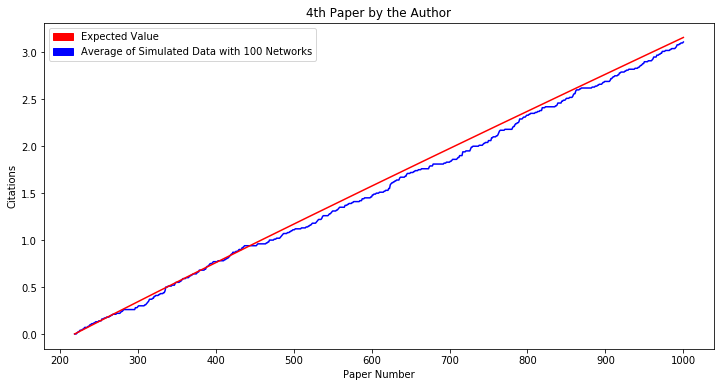

In [31]:
EV_network = buildEVnetwork(c, a, n)
plotBoth2(avg_network, EV_network, 4, rList, True)

In [33]:
def plotBoth_all(aNetwork, bNetwork, randomList, tru): #takes array value as well for EV
    length = len(aNetwork)
    xAxis = range(1, length+1)
    red_patch = mpatches.Patch(color='red', label='Expected Value')
    blue_patch = mpatches.Patch(color='blue', label='Average of Simulated Data with 100 Networks')
    for i in range(0, length):
        plt.plot(xAxis[i-1:], aNetwork[i-1].inDegList, color = 'blue')
        plt.plot(xAxis[i-1:], bNetwork[i-1], color = 'red')
    plt.xlabel('Paper Number')
    plt.ylabel('Citations')
    plt.title('Expected Value Network and Average Network')
    plt.legend(handles=[red_patch, blue_patch])
    plt.show()

This demonstrates how similar the EV and Avg are for multiple papers in the network

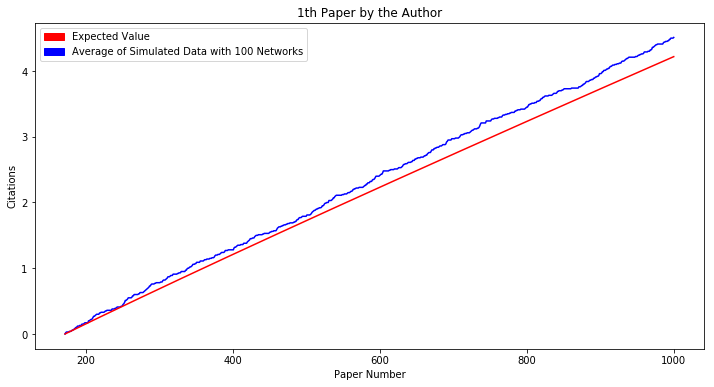

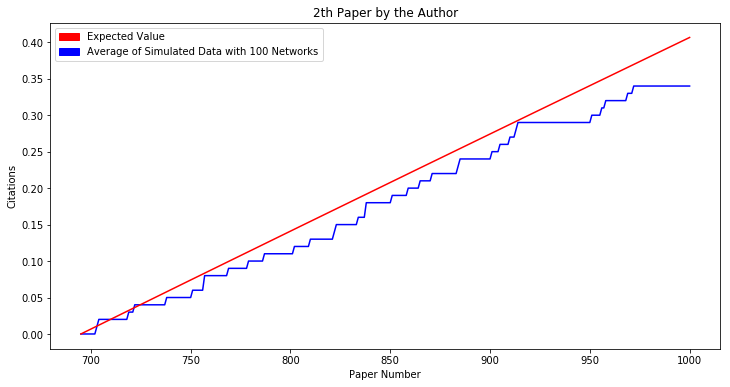

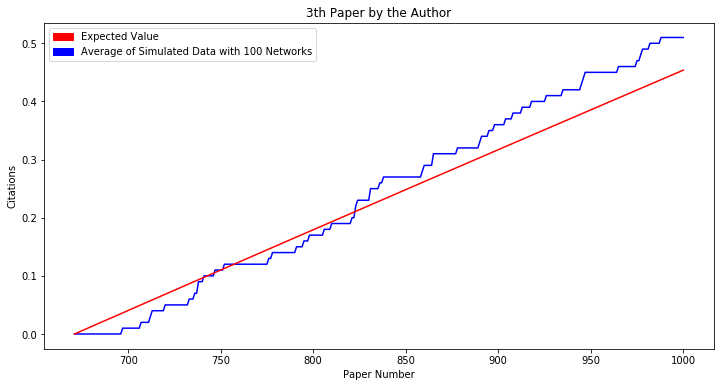

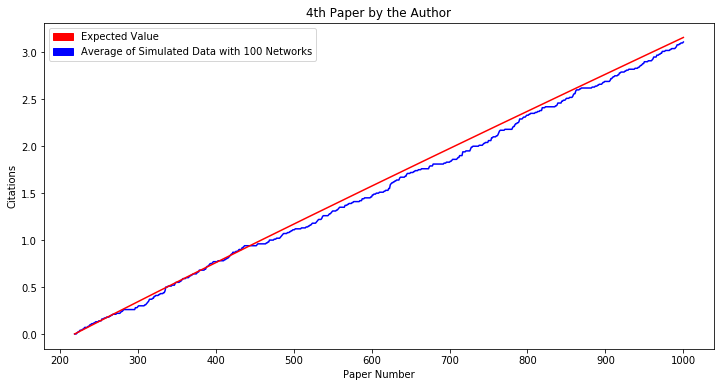

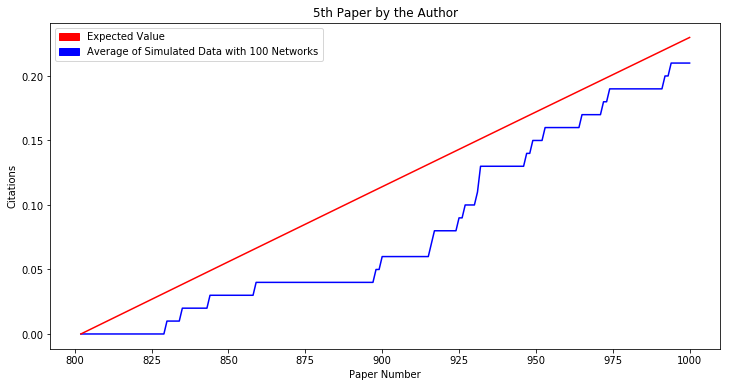

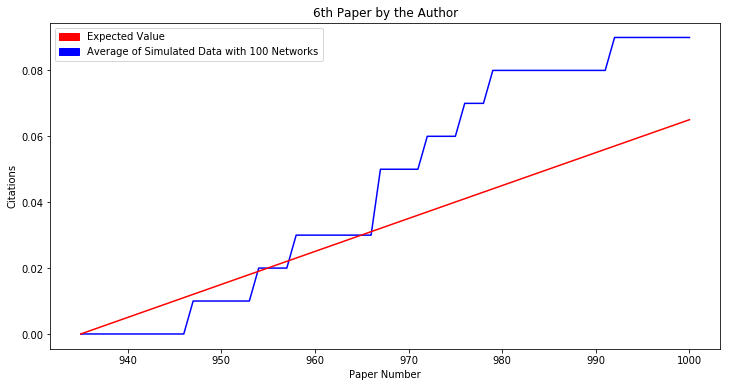

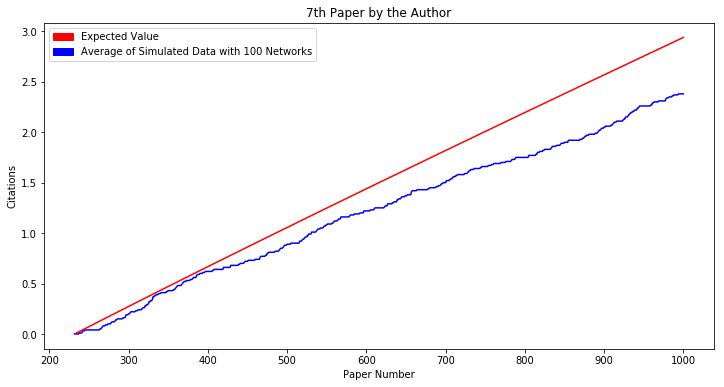

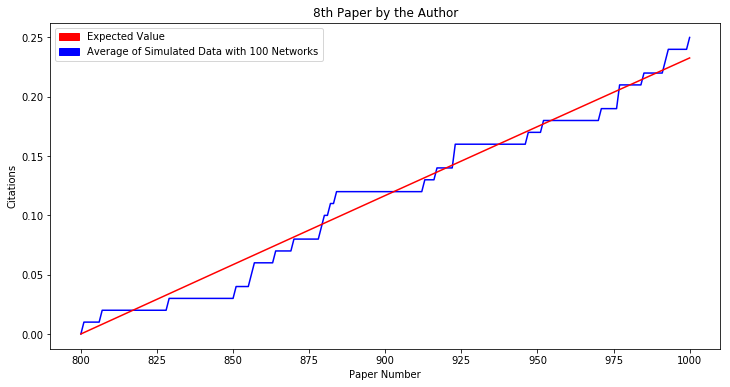

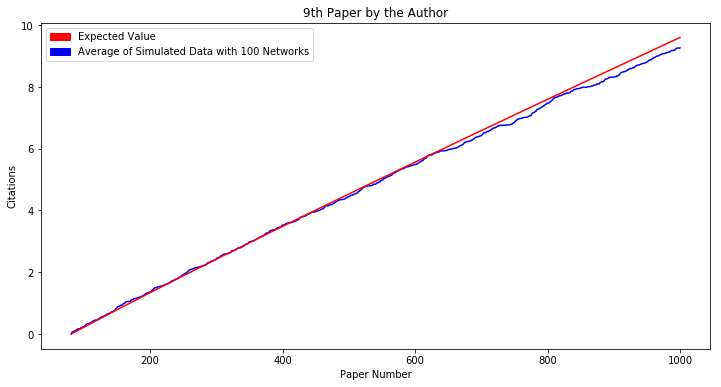

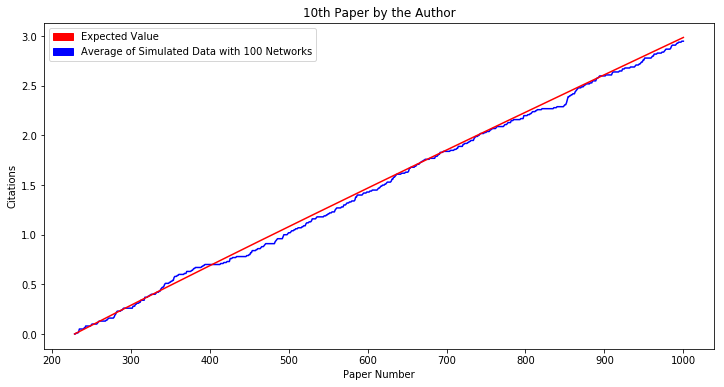

In [35]:
for i in range(1,len(rList[:10])+1):
    plotBoth2(avg_network, EV_network, i, rList, True)

Now we move to our $g(t)$ formulation, which predicts the number of citations the $j^{th}$ paper will obtain at time $n$

In [15]:
def theoreticalG(c, a , n, randomList): #should return the list of papers an author has up to time n/n+1
    beta = c/float(c+a)
    y = []
    for j in range(1,n+1):
        temp = a*(np.power(j/float(n+1), -beta) -1)
        y.append(temp)	
    return y

In [16]:
def plotGTheoretical(c, a, n):
    beta = c/float(c+a)
    x = range(1,n+1)
    y = []
    for i in x:
        temp = a*(np.power(i/float(n), -beta) -1)
        y.append(temp)
    plt.plot(x[1:],y[1:], color = 'red', label = 'g(t)')
    plt.legend()
    plt.savefig('g(t)')
    
    plt.show()

In [17]:
def plotGwithEV(EVarr, c, a):
    y = []
    x = range(1, len(EVarr)+1)
    #x = [i/len(EVarr) for i in x]
    plotGwithNetwork(aNetwork, c, a, string)
    for i in EVarr:
        y.append(i[-1])
    plt.plot(x[1:], y[1:])
    #plotGTheoretical(c, a, len(EVarr))
    
    plt.show()

In [18]:
def plotGwithNetwork(aNetwork, c, a, string): # plot the g(t) with the a network
    y = []
    x = range(1, len(aNetwork)+1)
    #x = [i/len(aNetwork) for i in x]
    for i in aNetwork:
        y.append(i.inDegList[-1])
    plt.plot(x[1:], y[1:], label = string)
    plt.xlabel('Paper Number')
    plt.ylabel('Citations')
    #plt.title('Theoretical g(t) and %s ' % string)
    
    #plotGTheoretical(c, a, len(aNetwork))
    

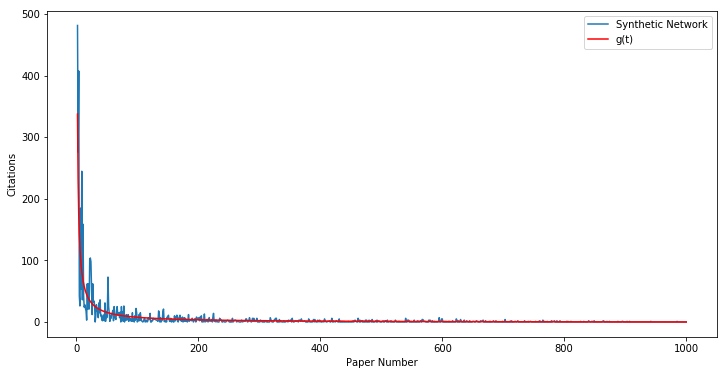

In [19]:
network = createNetworkSamplingWithRep(c, a, n)
plotGwithNetwork(network, c, a, 'Synthetic Network')
plotGTheoretical(c, a, n)

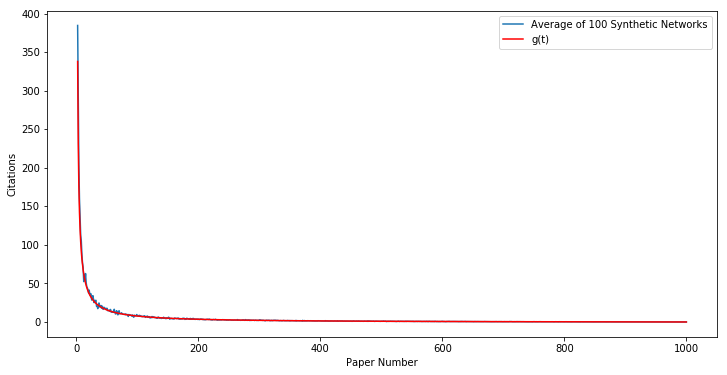

In [20]:
network = createNetworkSamplingWithRep(c, a, n)
plotGwithNetwork(avg_network, c, a, 'Average of 100 Synthetic Networks')
plotGTheoretical(c, a, n)

Finally, the $h-index$

These two functions find the $h-index$ at time $n$ for both $g(t)$ and a network

In [21]:
def network_hIndex_forTimet(aNetwork, randomList, n):
    newList = []
    for i in randomList:
        newList.append(aNetwork[i-1].inDegList[-1])
    newList.sort(reverse = True)
    k = 0
    while newList[k] >= k + 1:
        k += 1
    hIndex = k
    return hIndex

In [22]:
def G_hIndex_forTimet(y, randomList):
    newList = []
    for i in randomList:
        newList.append(y[i-1])
    k = 0
    while newList[k] >= k + 1:
        k += 1
    hIndex = k

    return hIndex

This function is makes a histogram of $N$ simulations of the $h-index$ for networks and $g(t)$, to demonstrate the validity of our prediction 

For simulation with pdf corresponding to the beta distribution, we assume the random list representing an authors papers in the network needs to be generated with uniform sampling

In [23]:
def generateListUniform(n, m): #generate list by sampling randomly
    rList = []
    n = range(1, n+1)
    rList.append(np.random.choice(n))
    while len(rList) < m:
        a = np.random.choice(n)
        if a not in rList:
            rList.append(a)
    return rList

In [24]:
def g_inverse(t, c, a):
    alpha = (c+a)/float(c)
    return np.power((1 + t/float(a)), -alpha)

In [25]:
def p_k_Erlang(x, k, lam):
    p_k = sp.stats.erlang.cdf(x*lam, k, loc=0, scale=1)
    return p_k

In [26]:
def p_k_Beta(x, k, m):
    p_k = sp.stats.beta.cdf(x, k, m-k+1, loc=0, scale=1)
    return p_k

In [27]:
def hDist_fromBeta(N, m, c, a):
    distribution = []
    for i in range(0, m+1): #i = k in our paper and note h=0 is almost probability 0
        if i == m:
            h = p_k_Beta(g_inverse(i, c, a), i, m)
        elif i==0:
            h = 1 - p_k_Beta(g_inverse(1, c, a), 1, m)
        else:
            h = p_k_Beta(g_inverse(i, c, a), i, m) - p_k_Beta(g_inverse(i+1, c, a), i+1, m)

        distribution.append(h)
    return distribution
    #plt.plot(np.multiply(N,distribution)[:11], 'ro')

In [28]:
def hDist_fromErlang(N, m, c, a):#still figuing this out
    distribution = []
    for i in range(0, m+1): #i = k in our paper and note h=0 is almost probability 0

        if i == m:
            h = p_k_Erlang(g_inverse(i, c, a), i, m)
        elif i == 0:
            h = 0
        else:
            h = p_k_Erlang(g_inverse(i, c, a), i, m) - p_k_Erlang(g_inverse(i+1, c, a), i+1, m)

        distribution.append(h)
    return distribution 
    

In [31]:
def histogram(N, c, a, n, p, m, with_hDist):
    hIndexG = []
    hIndexNet = []
    for i in range(1,N+1):
        #randomList = generateRandList(n, p)
        randomList = generateListUniform(n, m)
        randomList.sort()
        aNetwork = createNetworkSamplingWithRep(c, a, n)
        y = theoreticalG(c, a , n, randomList)
        hIndexG.append(G_hIndex_forTimet(y, randomList))
        hIndexNet.append(network_hIndex_forTimet(aNetwork, randomList, n))

    b = max(max(hIndexG), max(hIndexNet))+1
    bins = range(b)
    plt.figure(1)
    plt.hist(hIndexG, bins, color = 'orange')
    plt.xlabel('Citations')
    plt.ylabel('Frequency')
    plt.title('Predicted N = %i' % N)
    interactive(True)
    plt.show()
    plt.figure(2)
    plt.hist(hIndexNet, bins, color = 'blue')
    plt.xlabel('Citations')
    plt.ylabel('Frequency')
    plt.title('True N = %i' % N)
    plt.show()
    plt.figure(3)
    if with_hDist:
        distribution = hDist_fromBeta(N, m, c, a)
        #hDist_fromErlang(N, m, c, a)
    #plt.hist(hIndexNet, bins, color = 'blue')
    plt.hist([hIndexG, hIndexNet], bins, label = ['Predicted', 'True'])
    plt.plot(np.multiply(N,distribution)[:11], 'bo')
    plt.xlabel('Citations')
    plt.ylabel('Frequency')
    plt.title('N = %i' % N)
    plt.show
    #interactive(False)
    #raw_input()


In [32]:
#histogram(N, c, a, n, p, m, None)

In [33]:
#histogram(N, c, a, n, p, m, True)

In [34]:
def newNetworkMethod(c, a, n):
    samplingList = []
    paperList = []
    prob = c/float(c+a)
    network = [0] * n
    for i in range(1, n+1):
        if i == 1:
            paperList.append(i)
        else:
            tempList = []
            for j in range(c):
                if samplingList:
                    if random.uniform(0,1) <= prob:
                        s = random.choice(samplingList)
                        network[s-1] += 1
                        tempList.append(s)
                        
                    else:
                        k = random.choice(paperList)
                        network[k-1] += 1
                        tempList.append(k)
                else:
                    k = random.choice(paperList)
                    network[k-1] += 1
                    tempList.append(k)
            samplingList.extend(tempList)
            paperList.append(i)
    return network

In [35]:
def network_hIndex_forNewMethod(aNetwork, randomList, n):
    newList = []
    for i in randomList:
        newList.append(aNetwork[i-1])
    newList.sort(reverse = True)
    k = 0
    while newList[k] >= k + 1:
        k += 1
    hIndex = k
    return hIndex

In [44]:
def histogram2(N, c, a, n, p, m, with_hDist, avg_ = False):
    hIndexG = []
    hIndexNet = []
    network = np.array([0] * n)
    if avg_:
        for i in range(1, N+1):
            network += np.array(newNetworkMethod(c, a, n))
        aNetwork = list((1/N)*network)
    else:
        aNetwork = newNetworkMethod(c, a, n)
    for i in range(1,N+1):
        #randomList = generateRandList(n, p)
        randomList = generateRandList_uni(n, m)
        randomList.sort()
        
        y = theoreticalG(c, a , n, randomList)
        hIndexG.append(G_hIndex_forTimet(y, randomList))
        hIndexNet.append(network_hIndex_forNewMethod(aNetwork, randomList, n))

    b = max(max(hIndexG), max(hIndexNet))+1
    bins = range(b)

        #hDist_fromErlang(N, m, c, a)
    #plt.hist(hIndexNet, bins, color = 'blue')
    fig, ax = plt.subplots()
    ax.hist(hIndexNet, bins, label = 'Synthetic Network', density = True, align = 'left')
    #ax.hist([hIndexG, hIndexNet], bins, label = ['Predicted', 'True'])
    if with_hDist:
        distribution = hDist_fromBeta(N, m, c, a)
        ax.plot(distribution[:b], 'ro', label = 'Predicted h-index Distribution')
    ax.set_xlabel('h-index')
    ax.set_ylabel('$P(h-index = k | m={})$'.format(m))
    #ax.set_title('N = %i' % N)
    
    ax.legend()
    plt.savefig(str(m)+'synthetic')
    plt.show()
    #interactive(False)
    #raw_input()

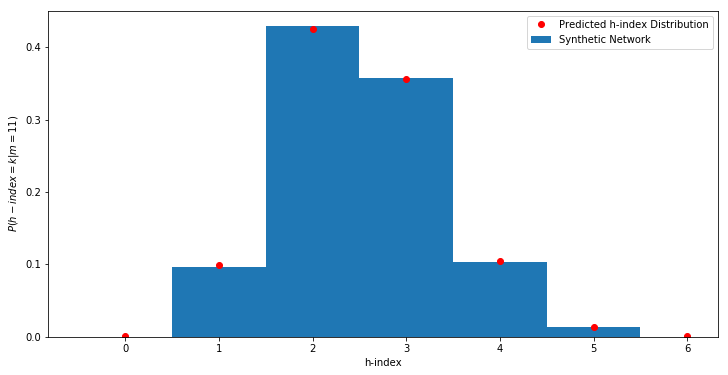

In [45]:
N = 1000
a = 1
m = 11
histogram2(N, c, a, n, p, m, True, avg_=True)

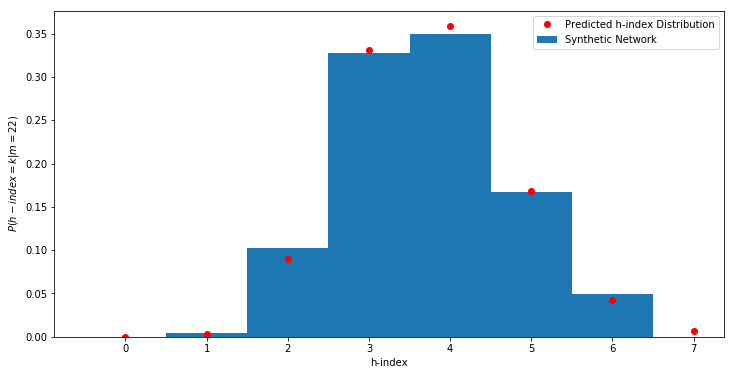

In [46]:
N = 1000
a = 1
m = 22
histogram2(N, c, a, n, p, m, True, avg_= True)

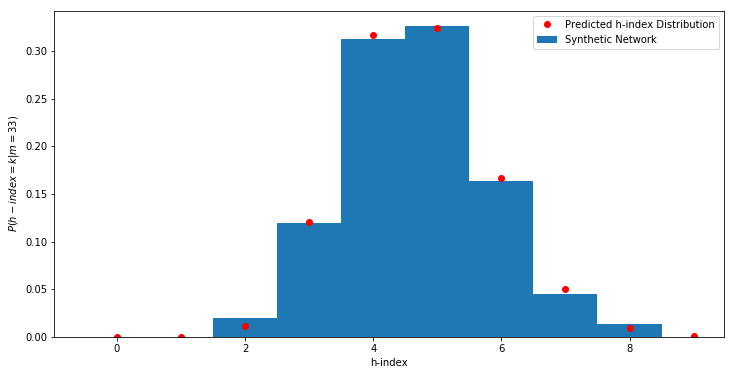

In [48]:
N = 1000
a = 1
m = 33
histogram2(N, c, a, n, p, m, True, avg_ = True)

N = 1000, n = 1000, c = 3, a = 1 and m = 50


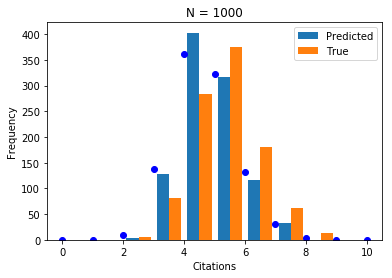

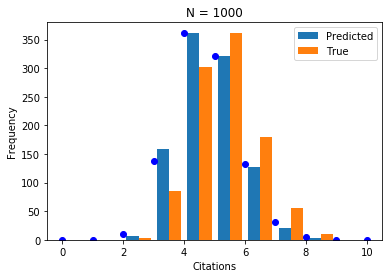

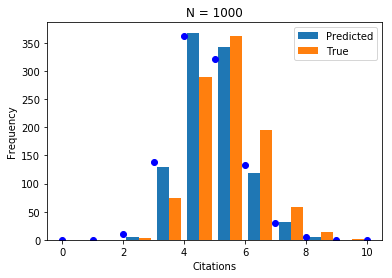

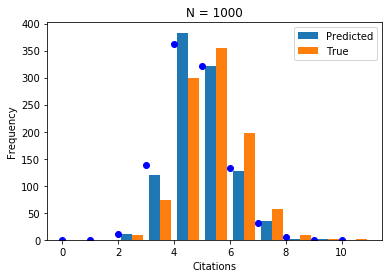

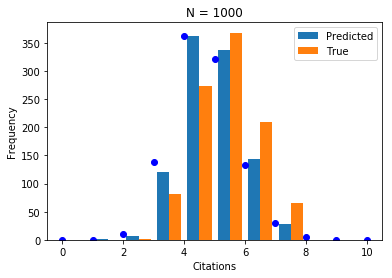

N = 1000, n = 1000, c = 3, a = 2 and m = 50


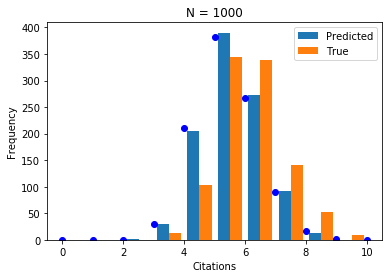

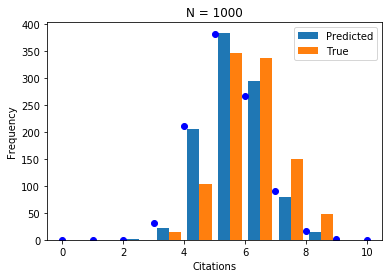

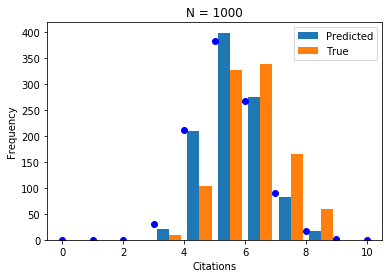

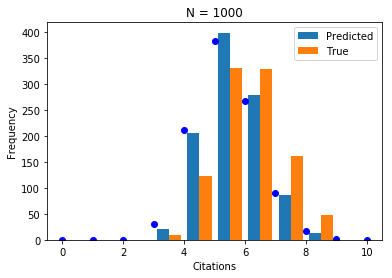

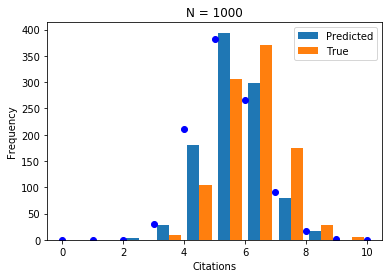

N = 1000, n = 1000, c = 3, a = 3 and m = 50


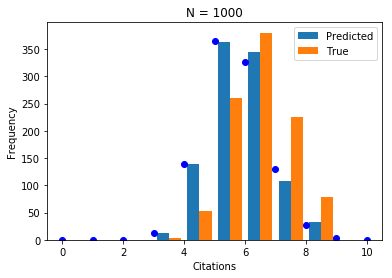

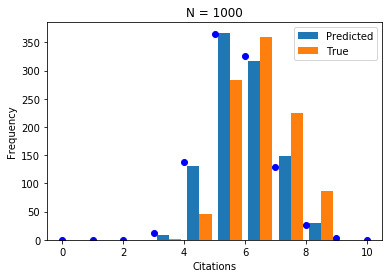

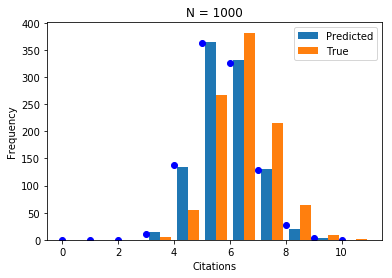

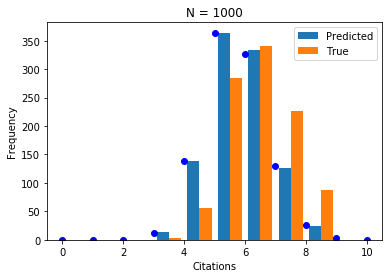

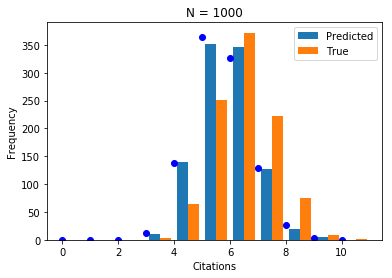

N = 1000, n = 1000, c = 5, a = 1 and m = 50


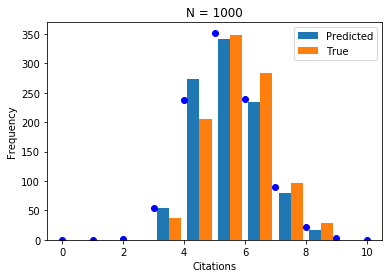

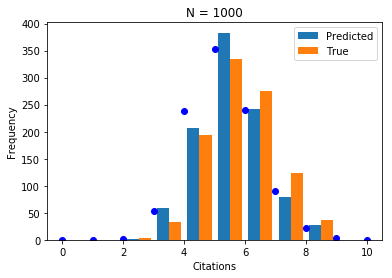

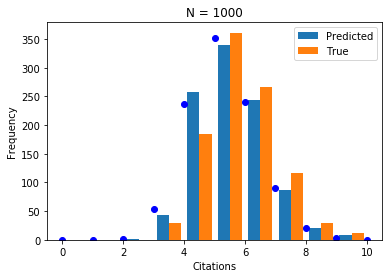

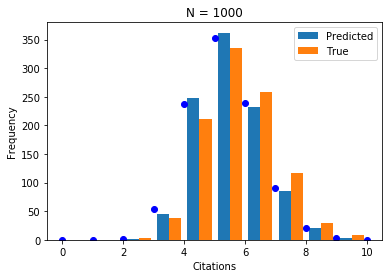

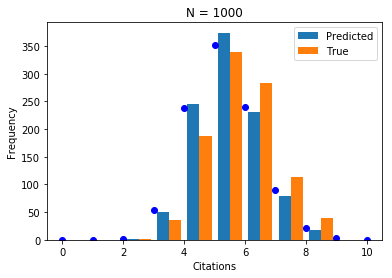

N = 1000, n = 1000, c = 5, a = 2 and m = 50


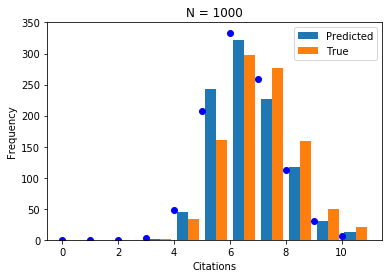

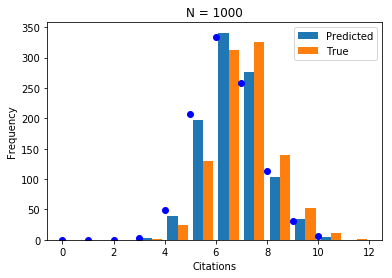

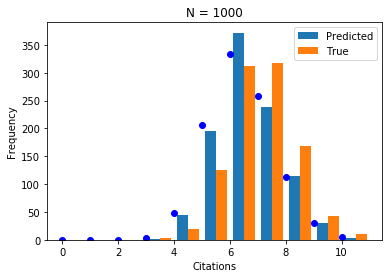

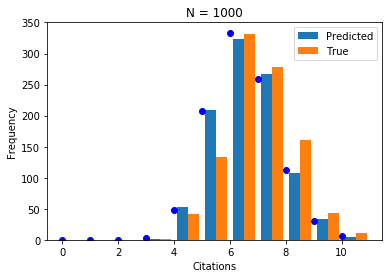

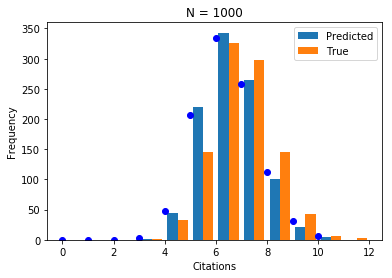

N = 1000, n = 1000, c = 5, a = 3 and m = 50


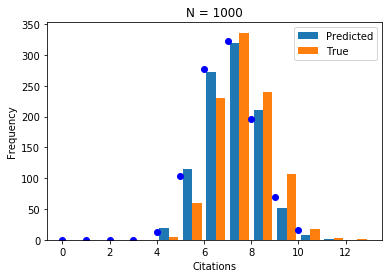

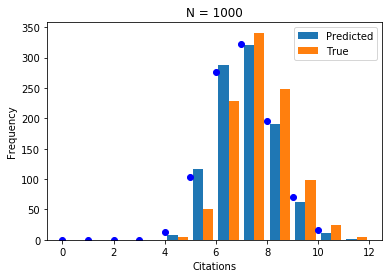

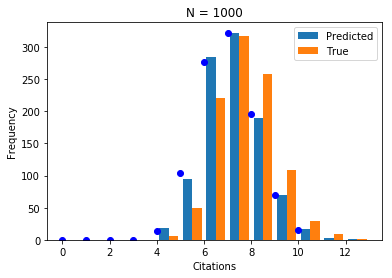

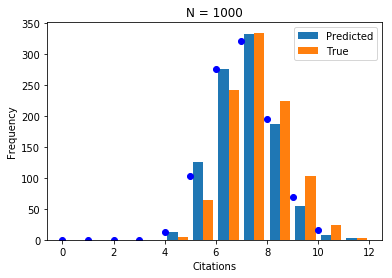

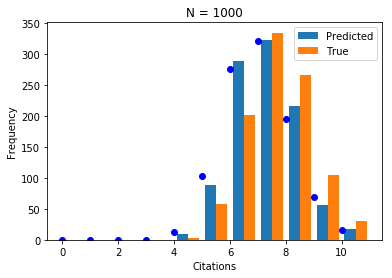

N = 1000, n = 1000, c = 10, a = 1 and m = 50


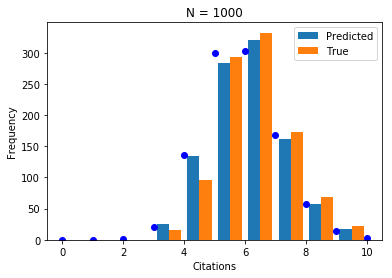

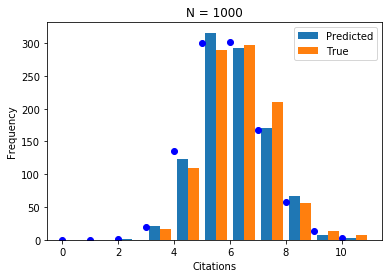

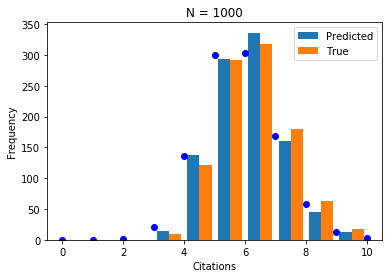

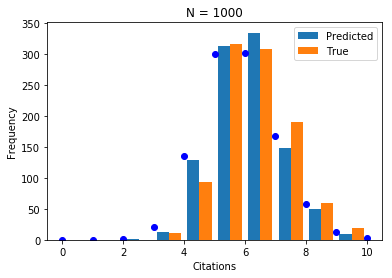

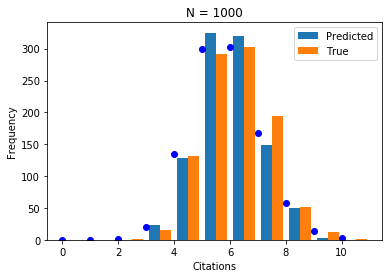

N = 1000, n = 1000, c = 10, a = 2 and m = 50


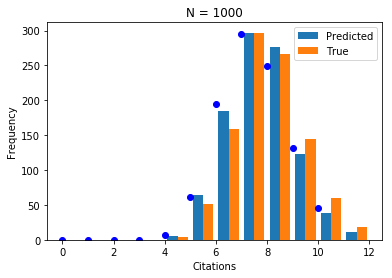

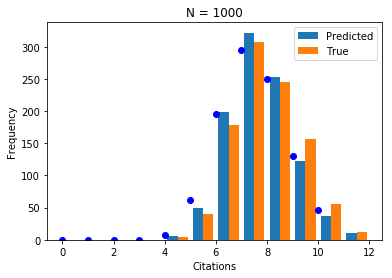

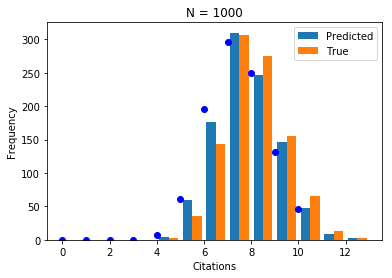

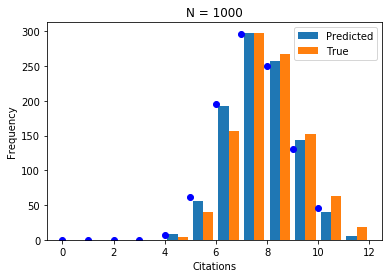

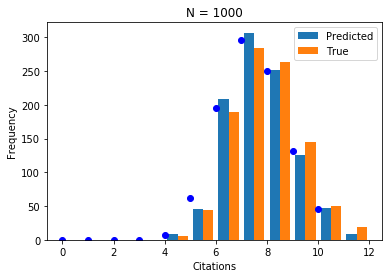

N = 1000, n = 1000, c = 10, a = 3 and m = 50


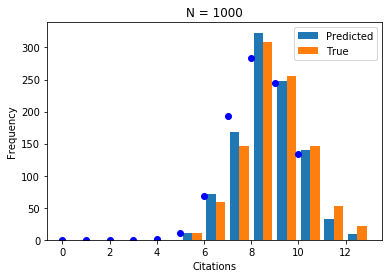

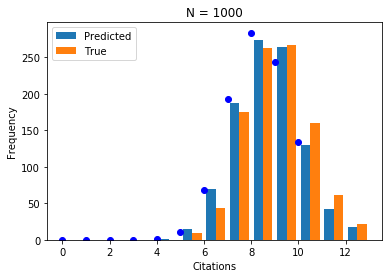

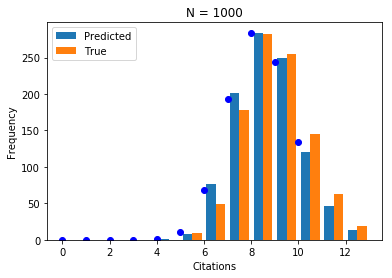

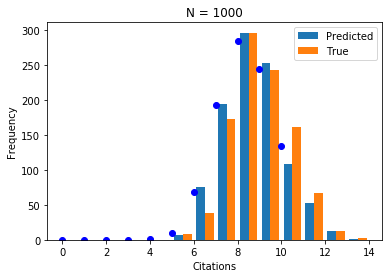

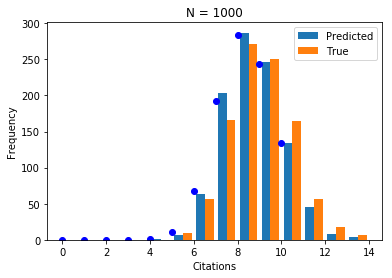

N = 1000, n = 1000, c = 15, a = 1 and m = 50


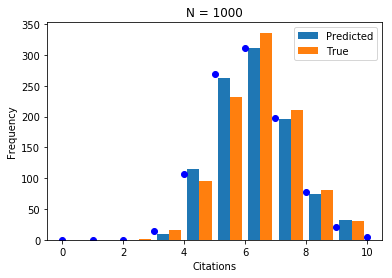

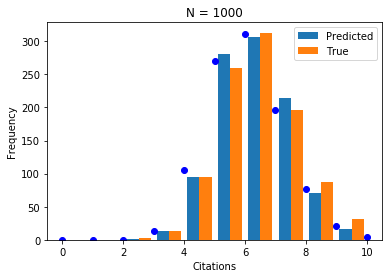

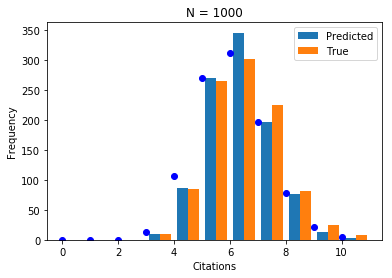

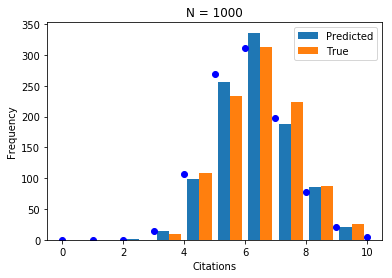

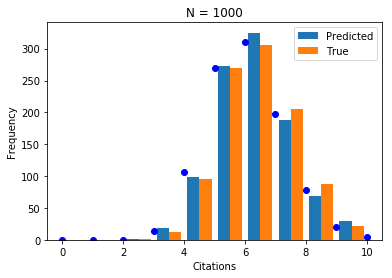

N = 1000, n = 1000, c = 15, a = 2 and m = 50


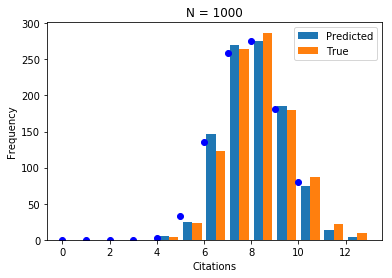

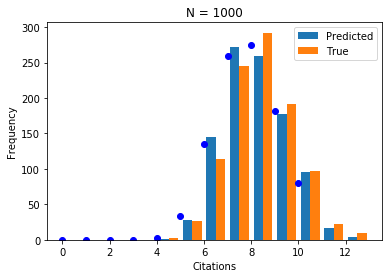

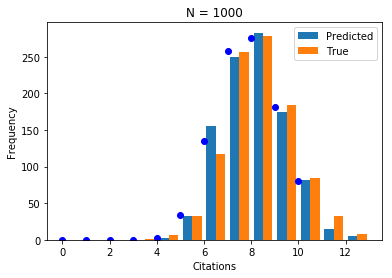

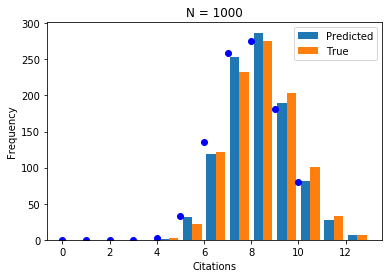

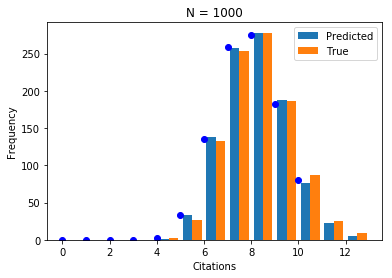

N = 1000, n = 1000, c = 15, a = 3 and m = 50


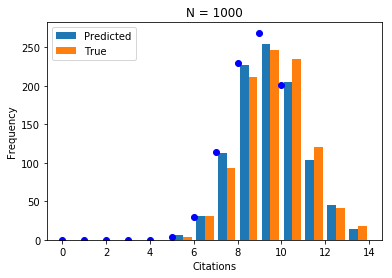

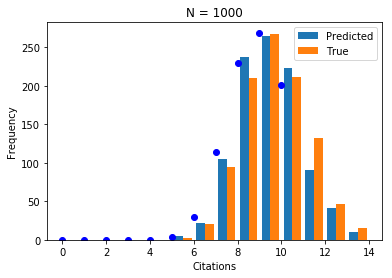

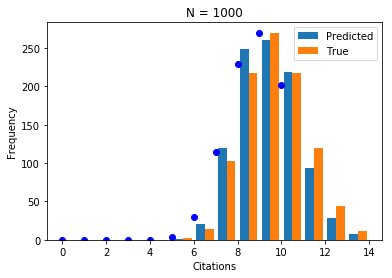

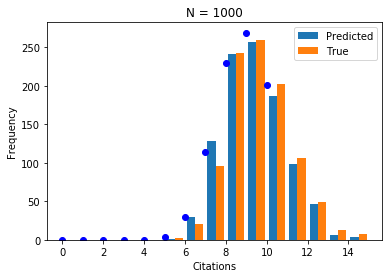

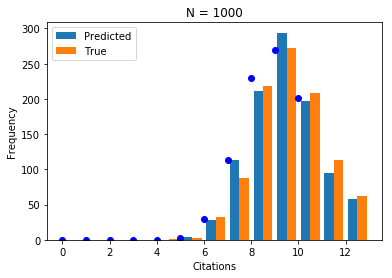

N = 1000, n = 3000, c = 3, a = 1 and m = 50


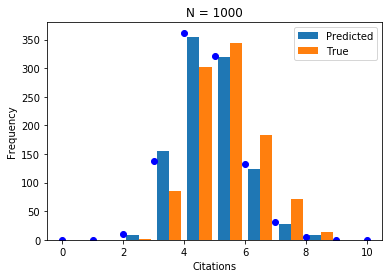

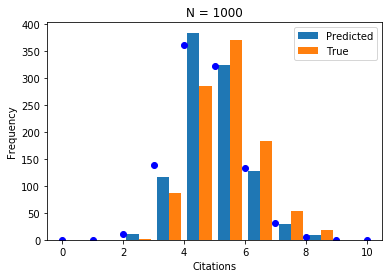

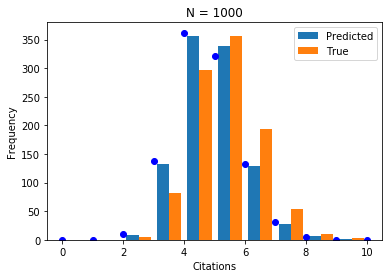

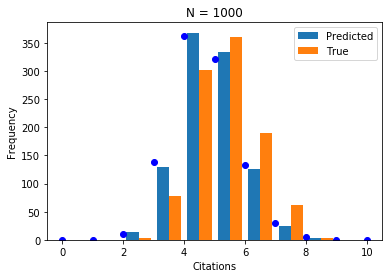

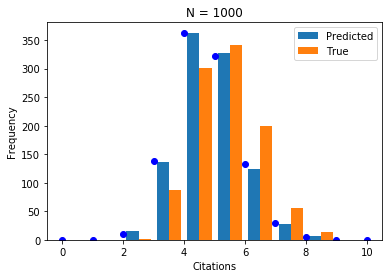

N = 1000, n = 3000, c = 3, a = 2 and m = 50


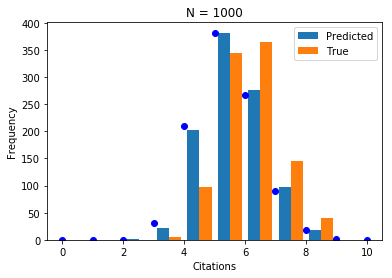

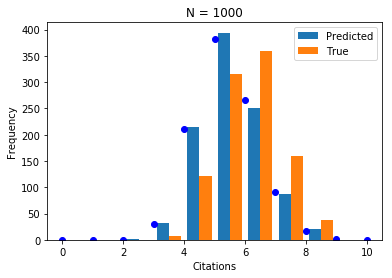

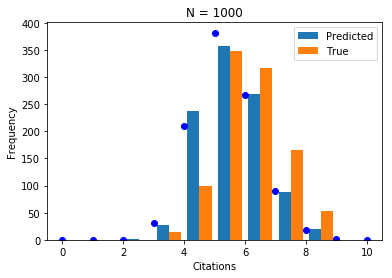

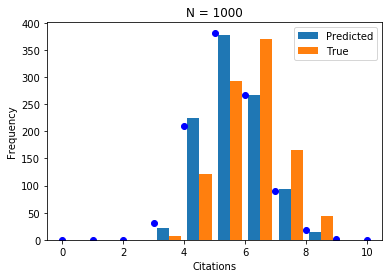

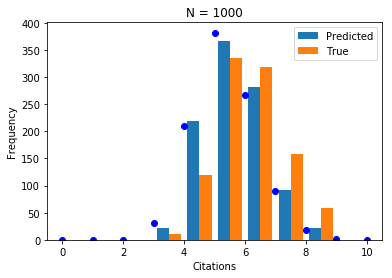

N = 1000, n = 3000, c = 3, a = 3 and m = 50


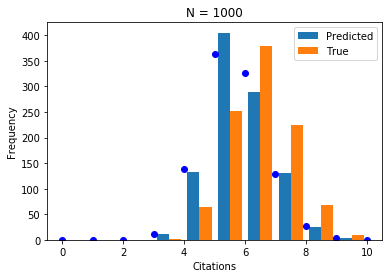

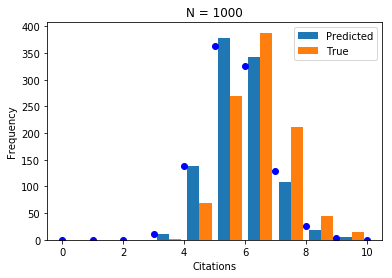

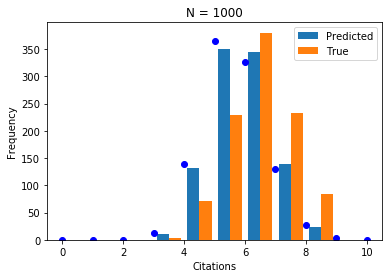

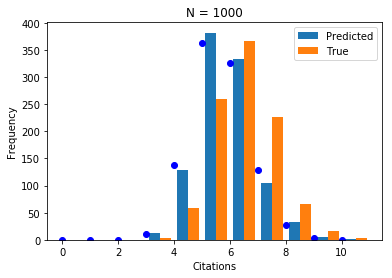

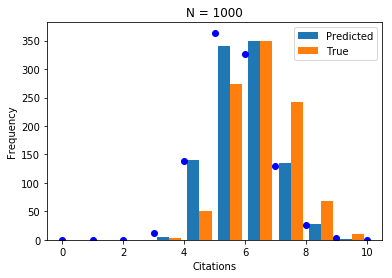

N = 1000, n = 3000, c = 5, a = 1 and m = 50


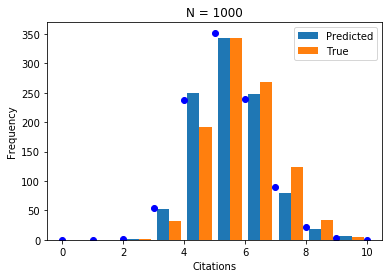

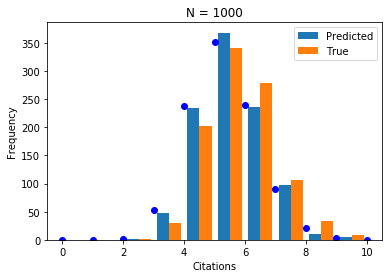

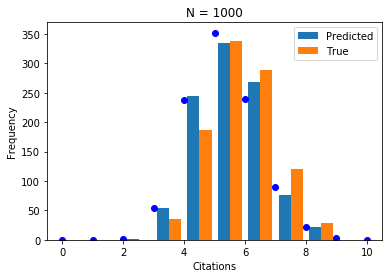

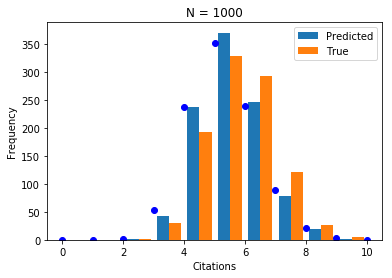

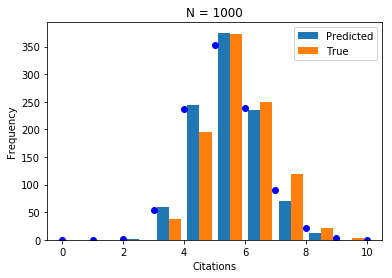

N = 1000, n = 3000, c = 5, a = 2 and m = 50


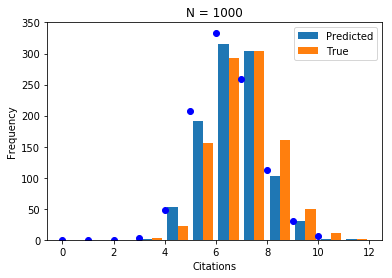

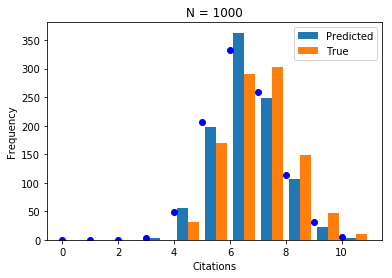

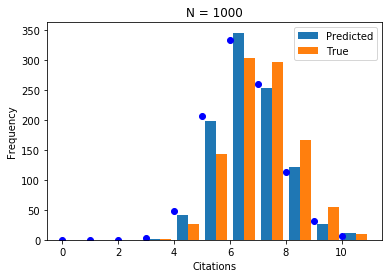

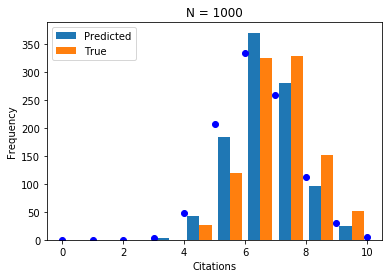

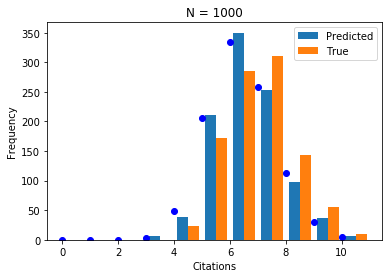

N = 1000, n = 3000, c = 5, a = 3 and m = 50


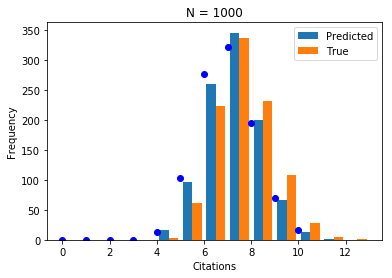

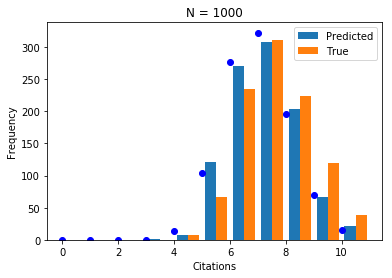

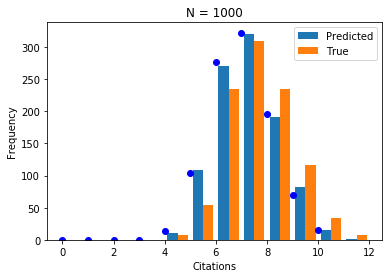

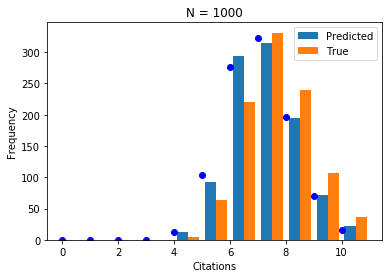

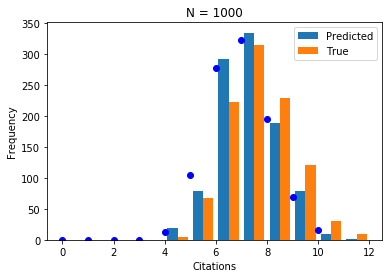

N = 1000, n = 3000, c = 10, a = 1 and m = 50


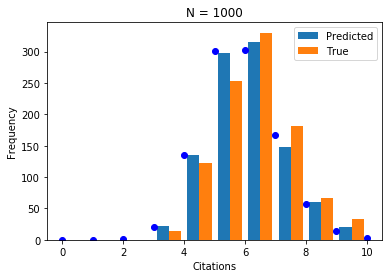

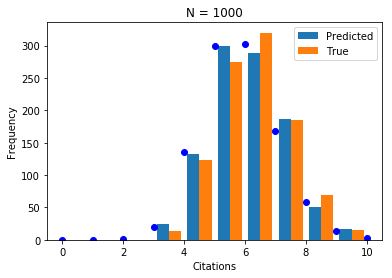

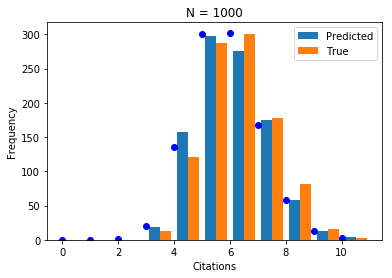

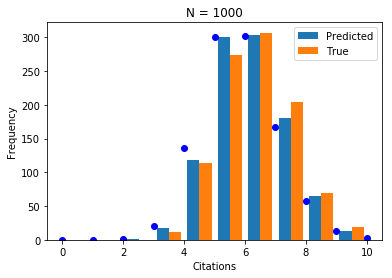

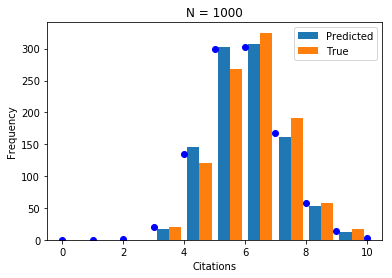

N = 1000, n = 3000, c = 10, a = 2 and m = 50


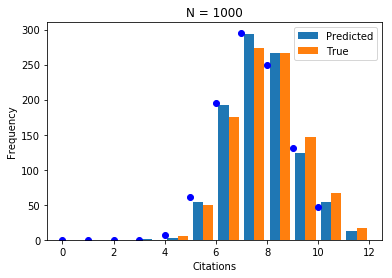

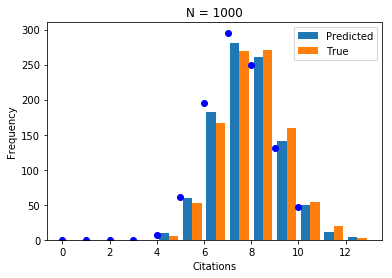

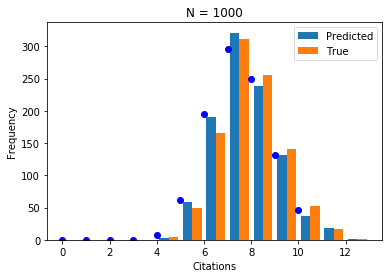

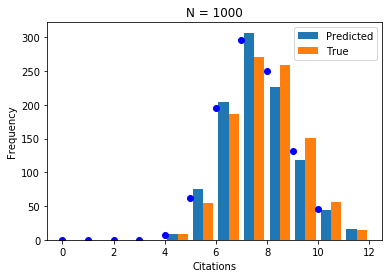

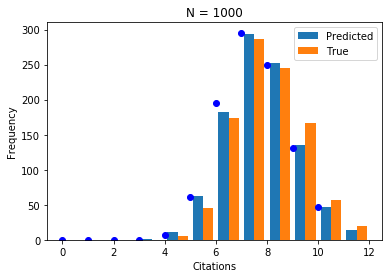

N = 1000, n = 3000, c = 10, a = 3 and m = 50


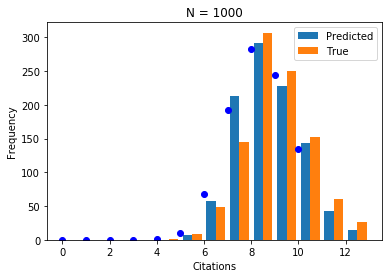

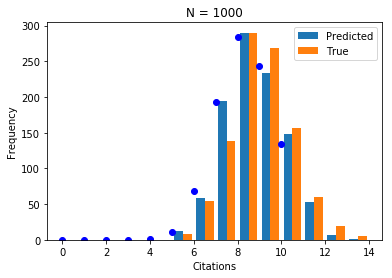

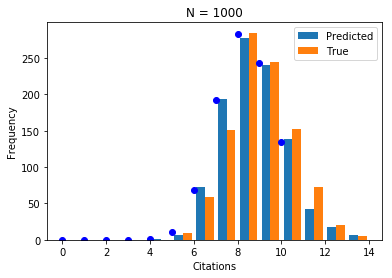

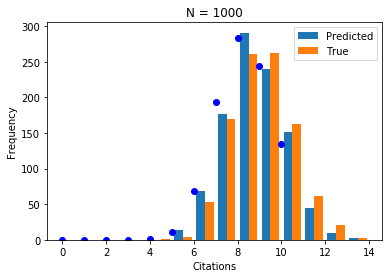

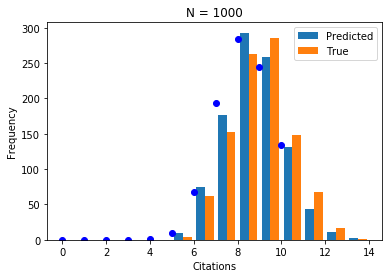

N = 1000, n = 3000, c = 15, a = 1 and m = 50


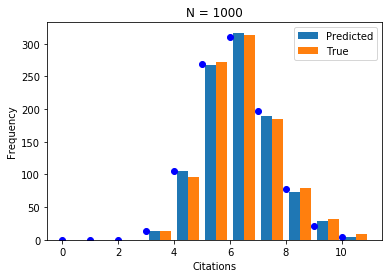

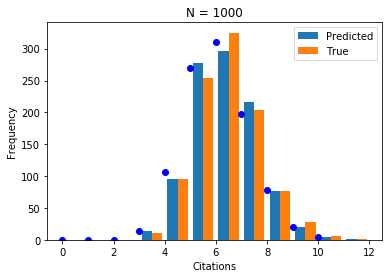

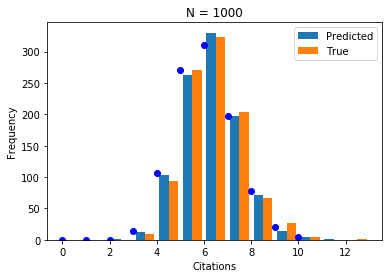

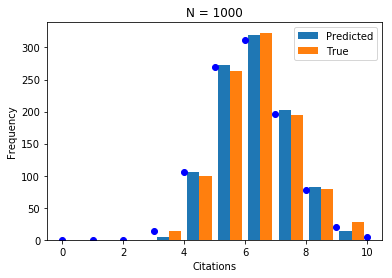

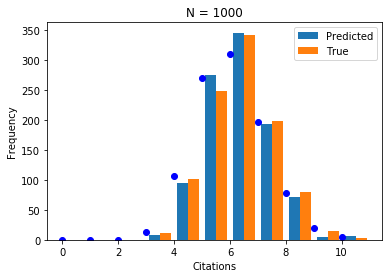

N = 1000, n = 3000, c = 15, a = 2 and m = 50


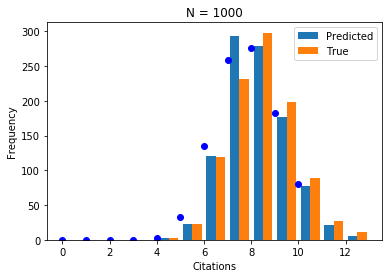

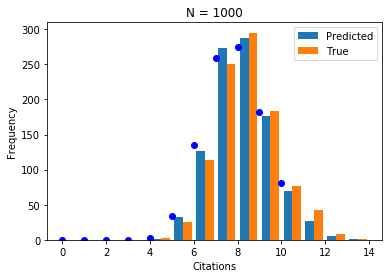

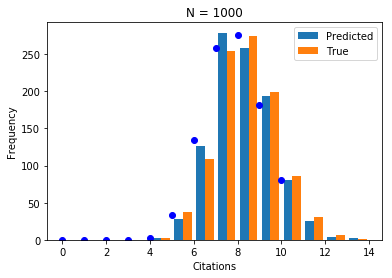

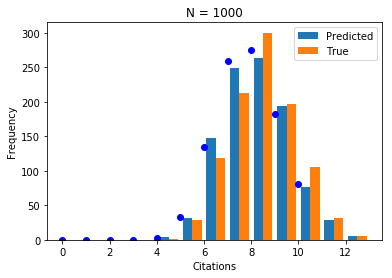

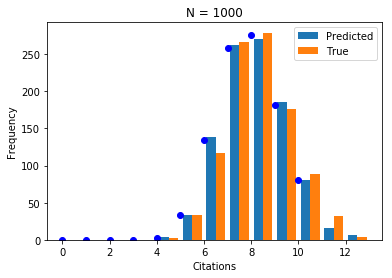

N = 1000, n = 3000, c = 15, a = 3 and m = 50


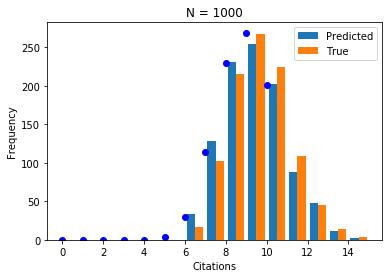

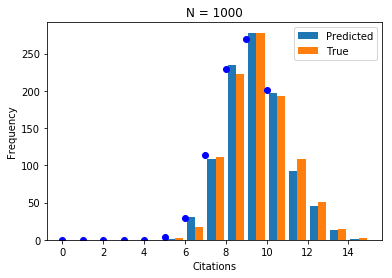

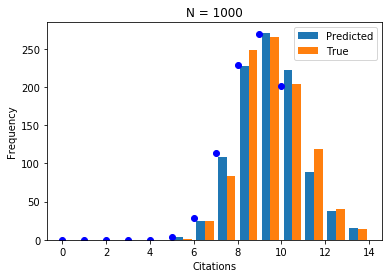

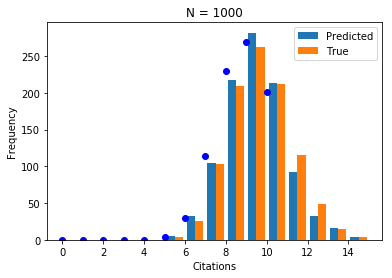

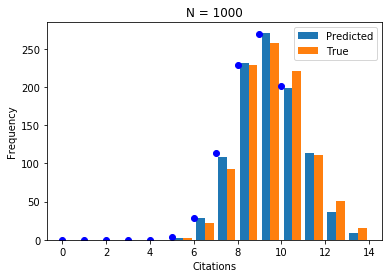

N = 1000, n = 5000, c = 3, a = 1 and m = 50


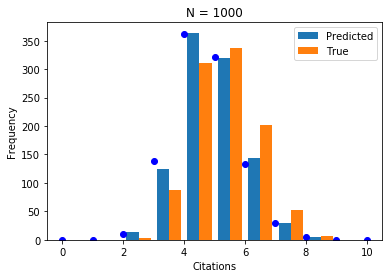

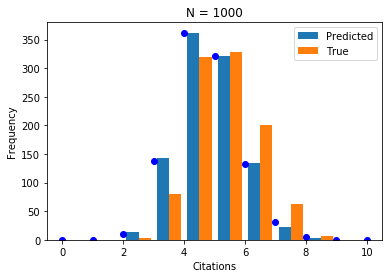

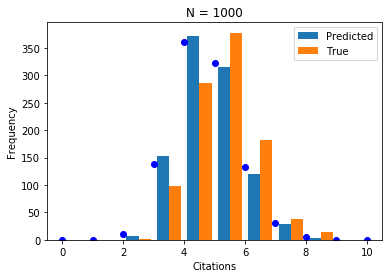

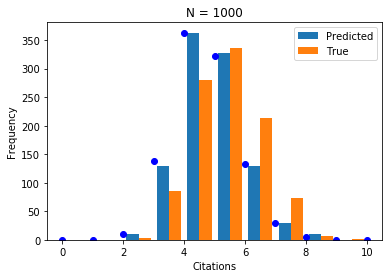

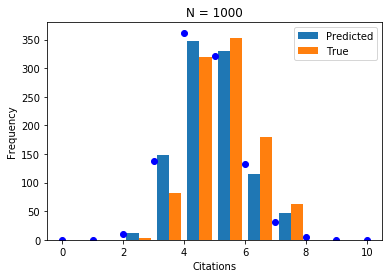

N = 1000, n = 5000, c = 3, a = 2 and m = 50


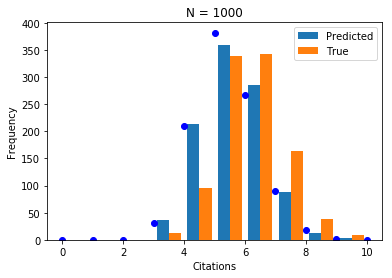

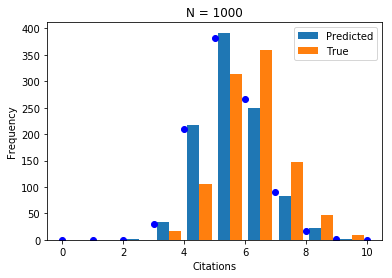

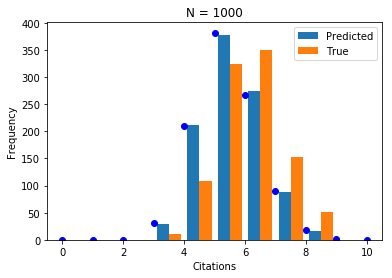

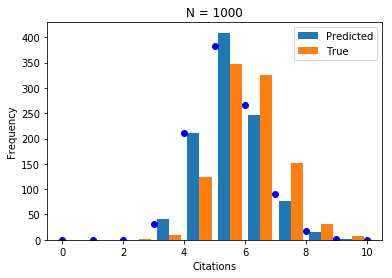

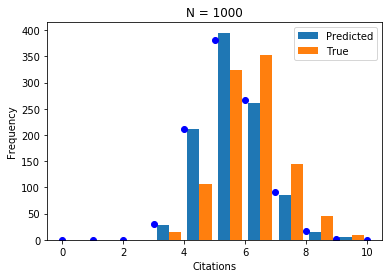

N = 1000, n = 5000, c = 3, a = 3 and m = 50


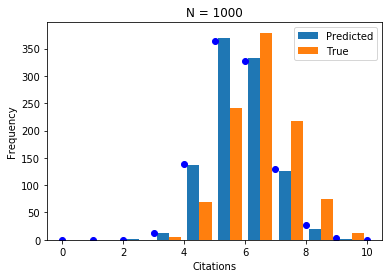

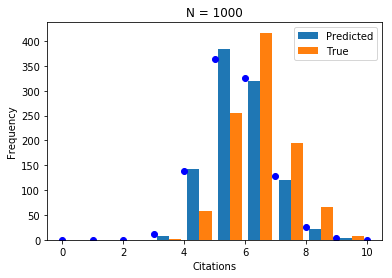

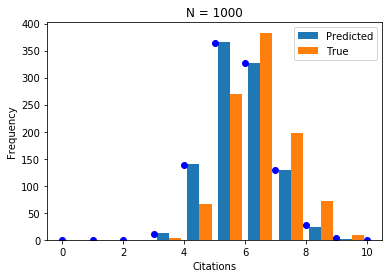

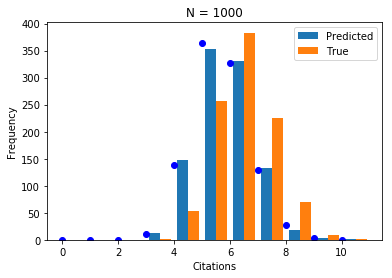

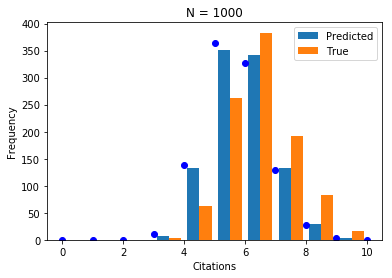

N = 1000, n = 5000, c = 5, a = 1 and m = 50


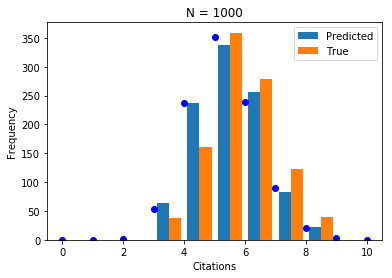

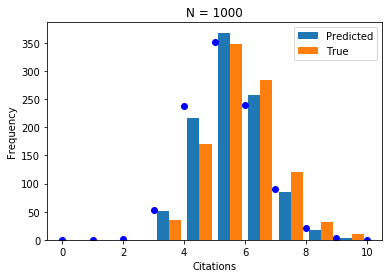

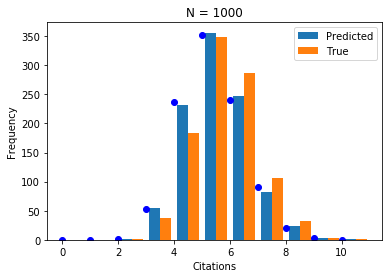

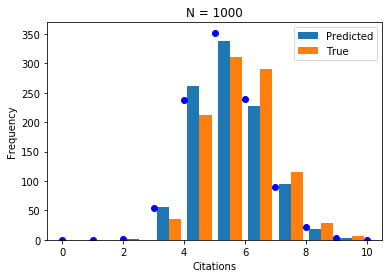

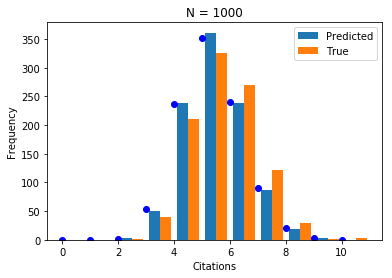

N = 1000, n = 5000, c = 5, a = 2 and m = 50


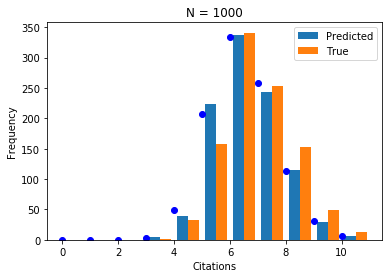

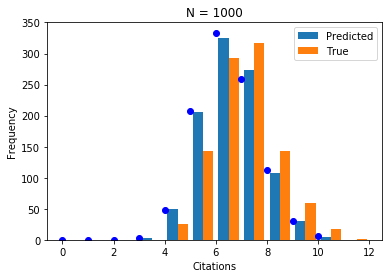

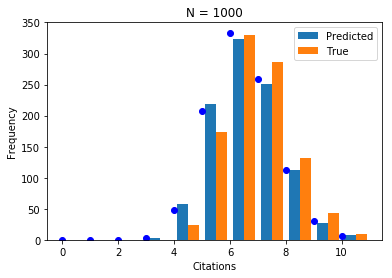

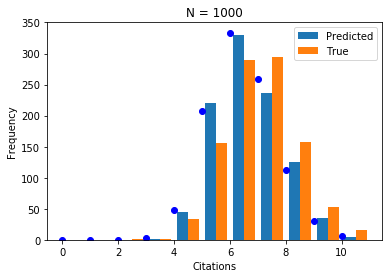

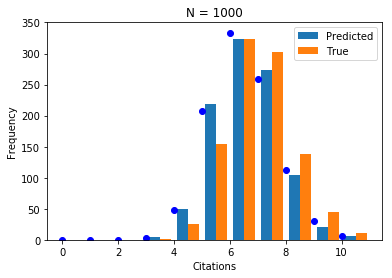

N = 1000, n = 5000, c = 5, a = 3 and m = 50


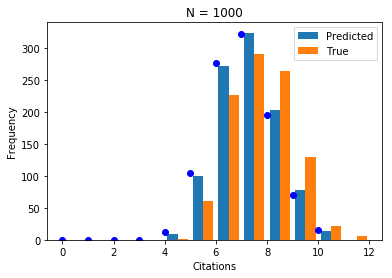

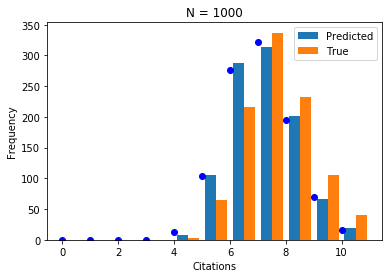

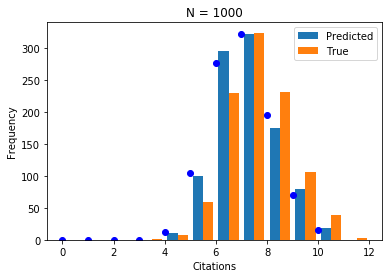

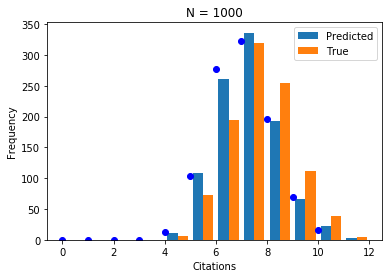

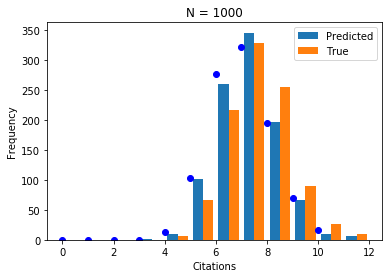

N = 1000, n = 5000, c = 10, a = 1 and m = 50


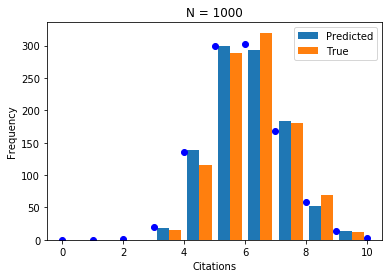

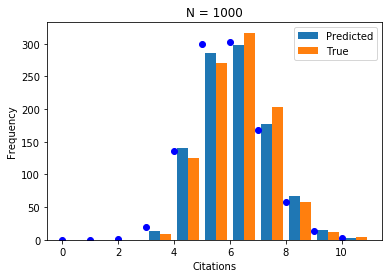

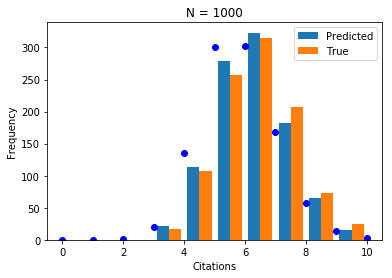

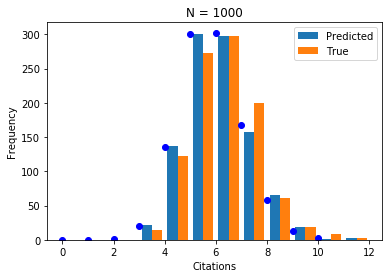

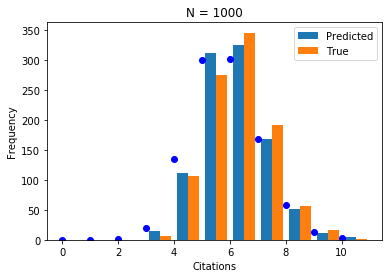

N = 1000, n = 5000, c = 10, a = 2 and m = 50


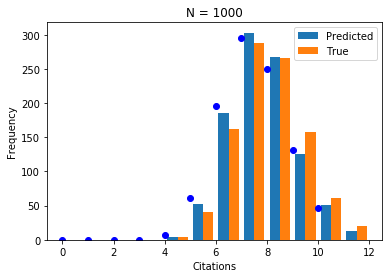

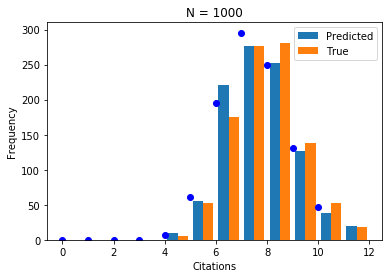

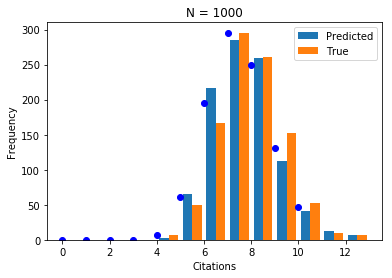

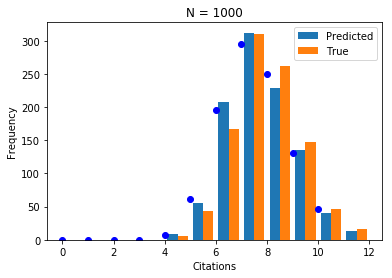

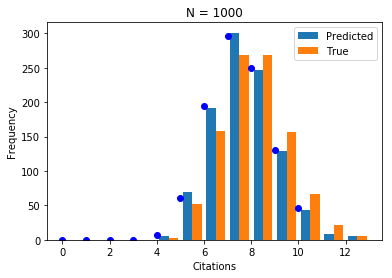

N = 1000, n = 5000, c = 10, a = 3 and m = 50


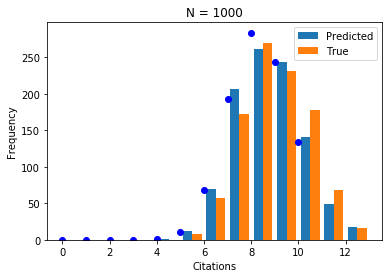

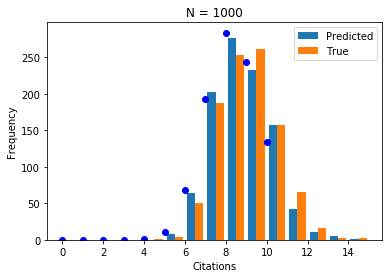

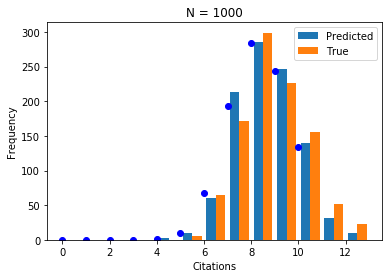

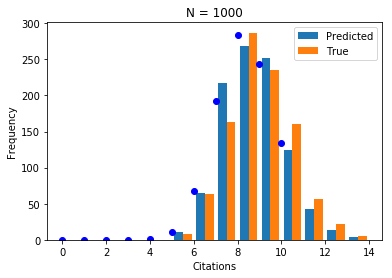

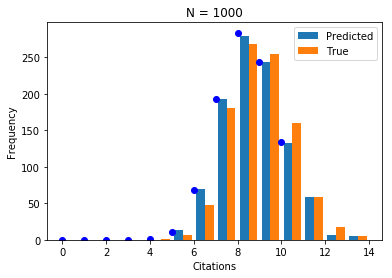

N = 1000, n = 5000, c = 15, a = 1 and m = 50


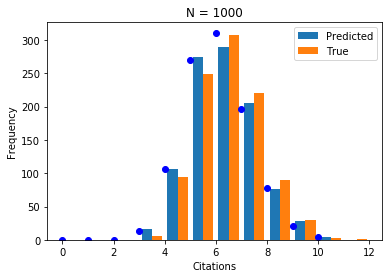

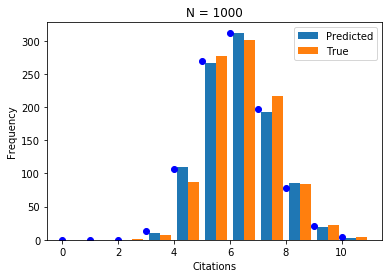

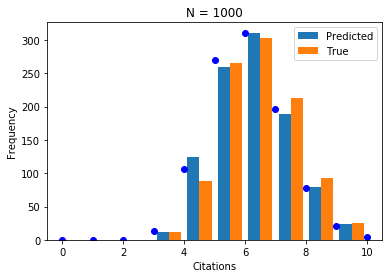

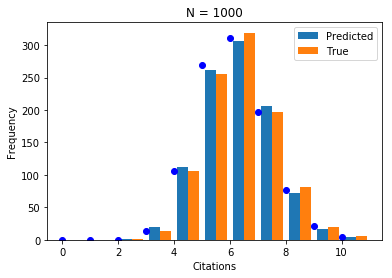

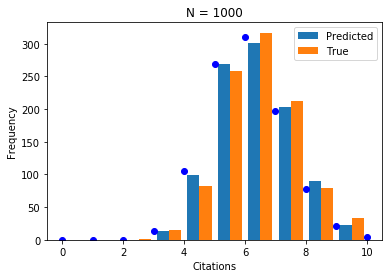

N = 1000, n = 5000, c = 15, a = 2 and m = 50


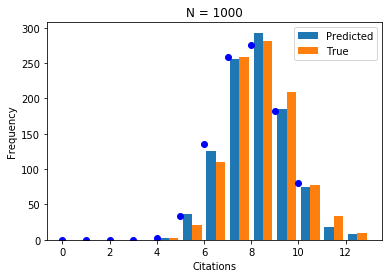

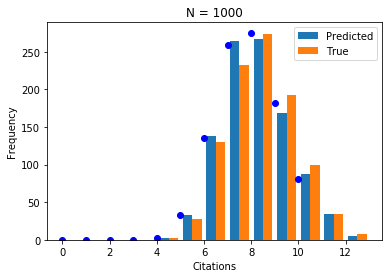

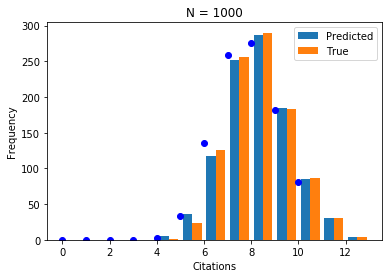

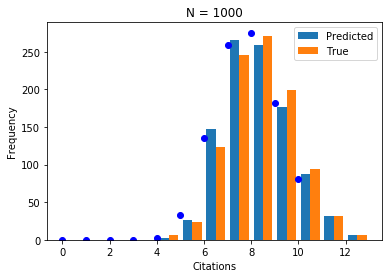

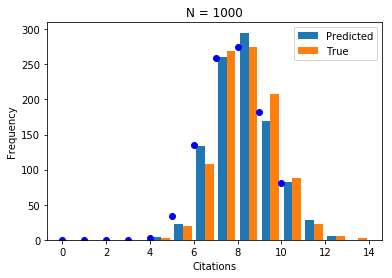

N = 1000, n = 5000, c = 15, a = 3 and m = 50


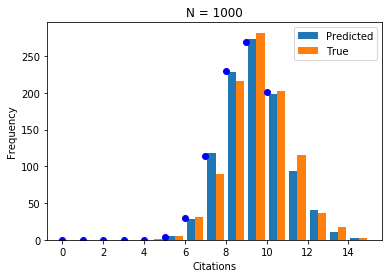

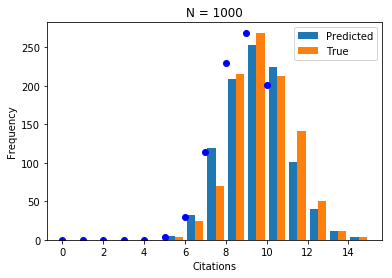

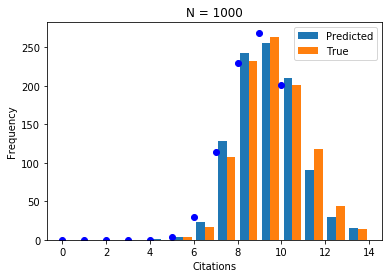

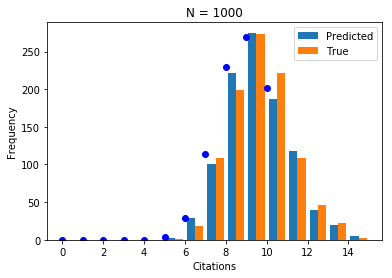

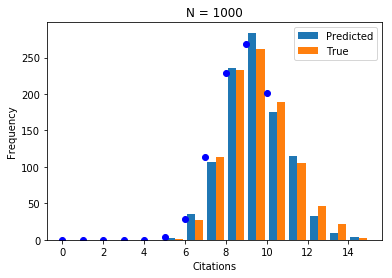

N = 3000, n = 1000, c = 3, a = 1 and m = 50


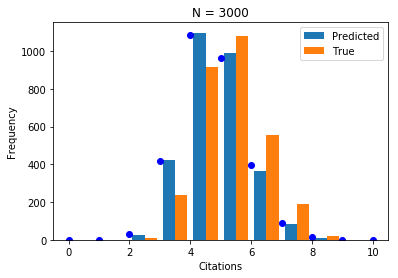

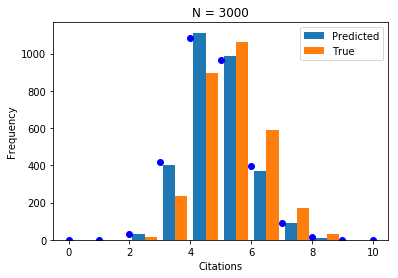

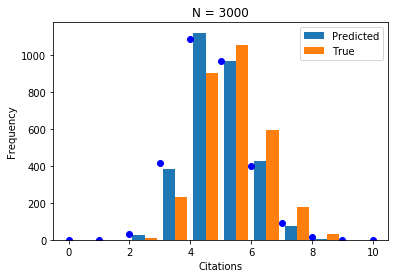

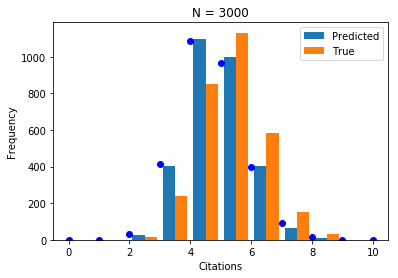

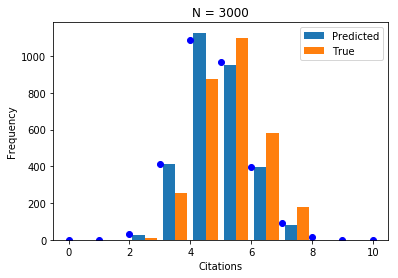

N = 3000, n = 1000, c = 3, a = 2 and m = 50


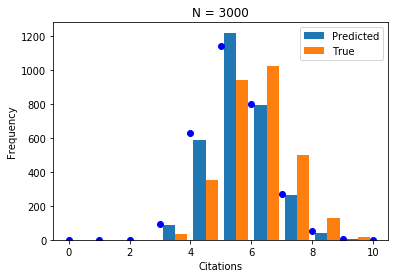

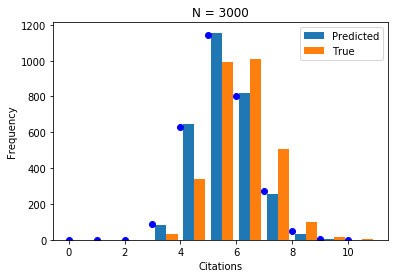

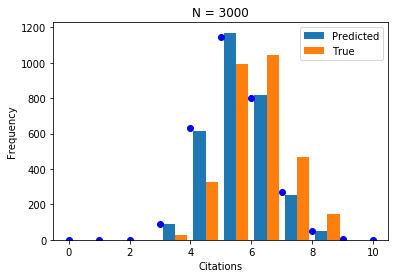

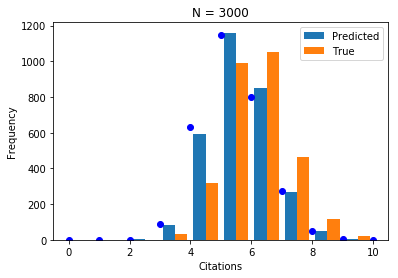

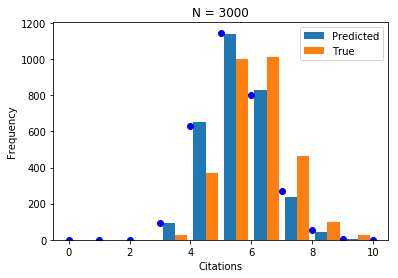

N = 3000, n = 1000, c = 3, a = 3 and m = 50


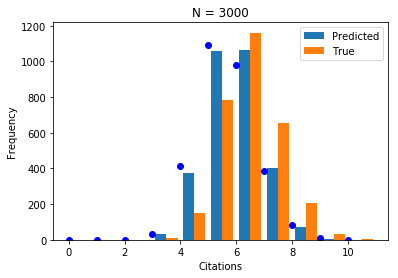

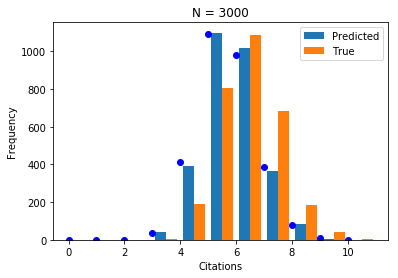

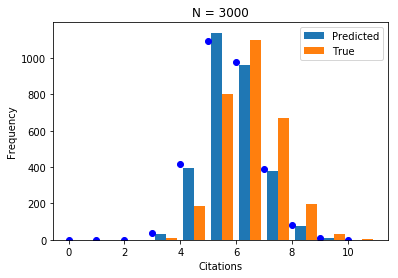

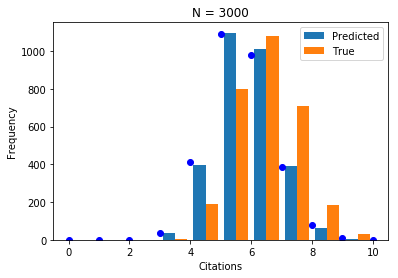

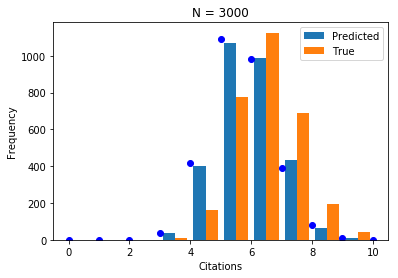

N = 3000, n = 1000, c = 5, a = 1 and m = 50


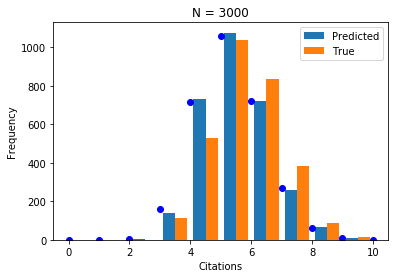

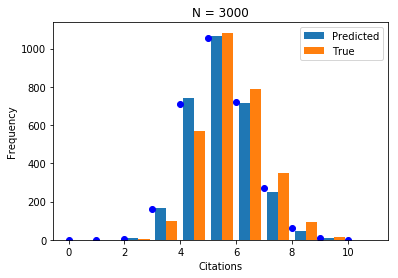

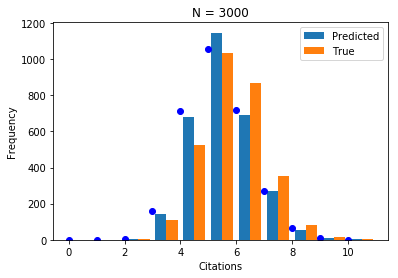

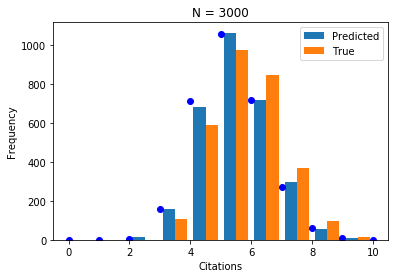

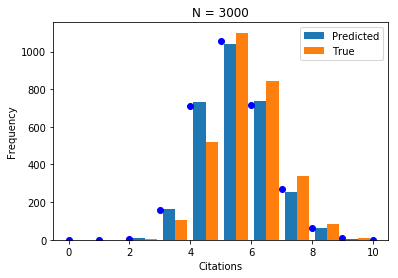

N = 3000, n = 1000, c = 5, a = 2 and m = 50


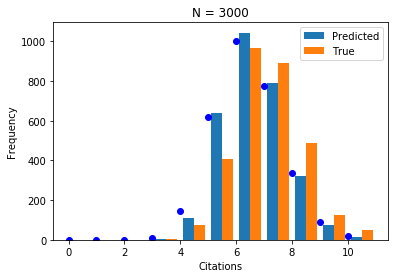

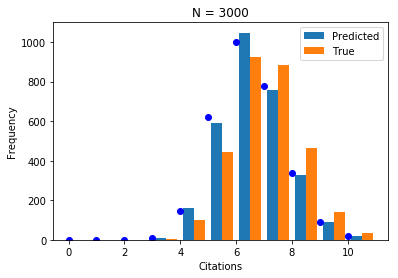

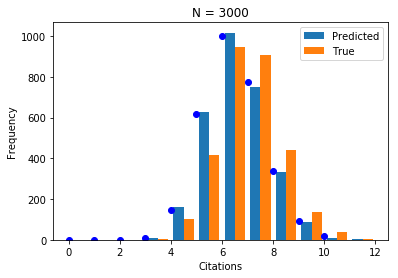

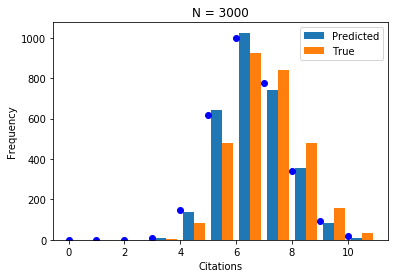

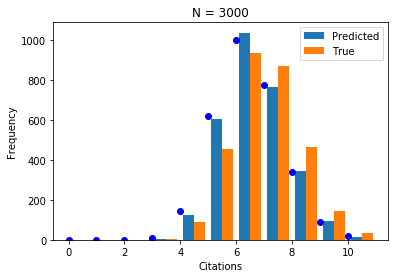

N = 3000, n = 1000, c = 5, a = 3 and m = 50


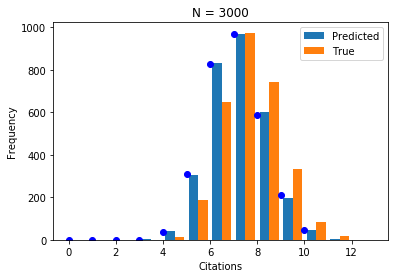

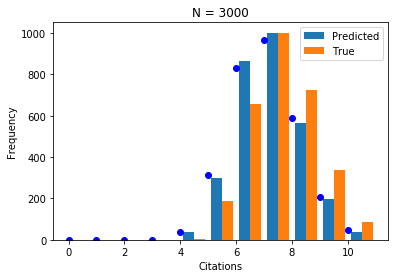

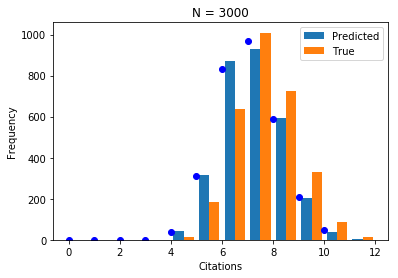

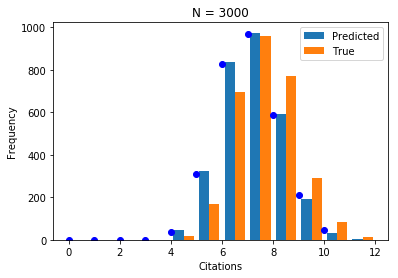

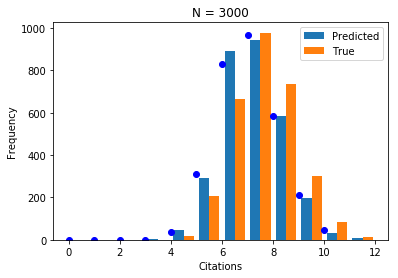

N = 3000, n = 1000, c = 10, a = 1 and m = 50


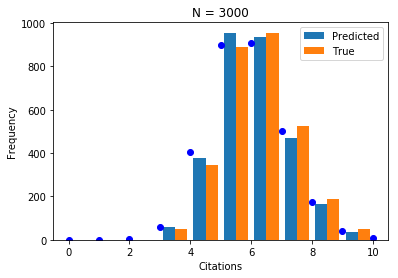

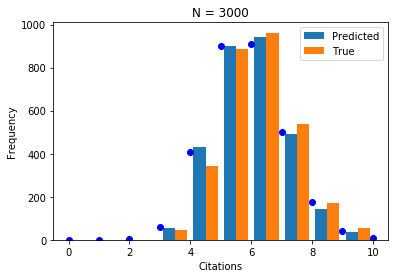

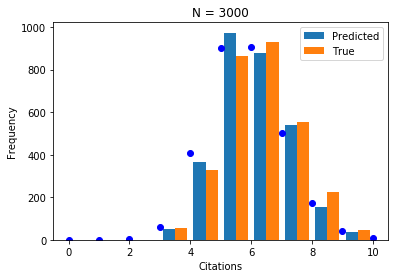

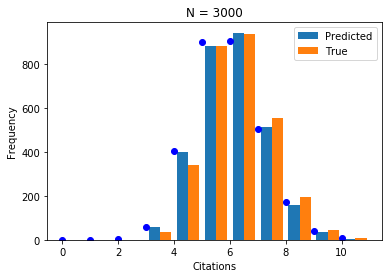

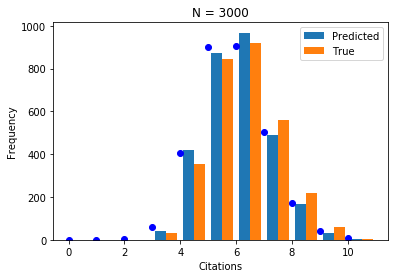

N = 3000, n = 1000, c = 10, a = 2 and m = 50


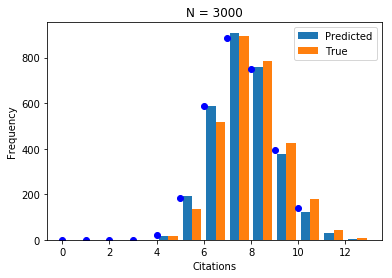

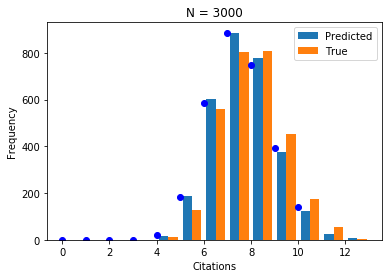

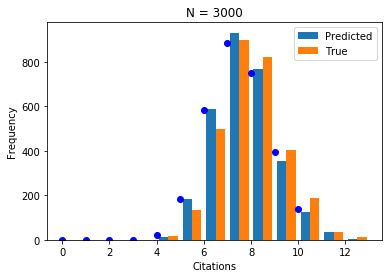

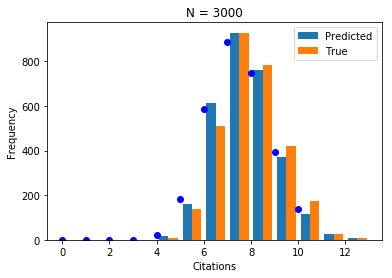

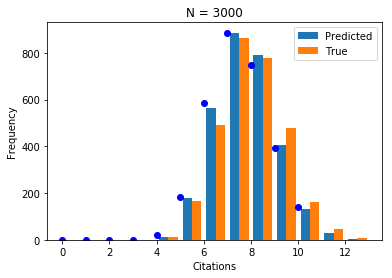

N = 3000, n = 1000, c = 10, a = 3 and m = 50


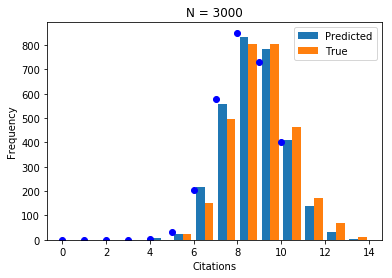

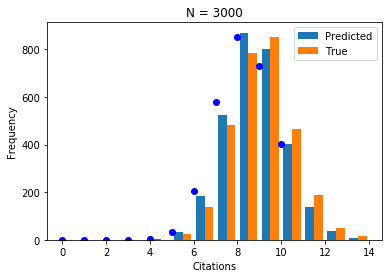

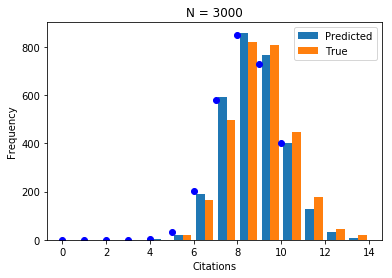

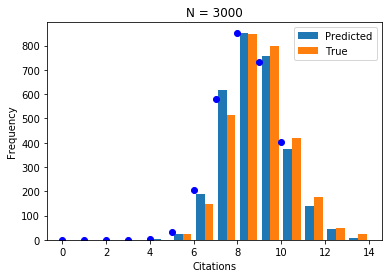

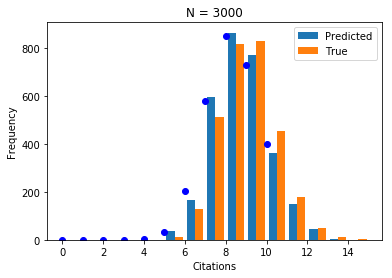

N = 3000, n = 1000, c = 15, a = 1 and m = 50


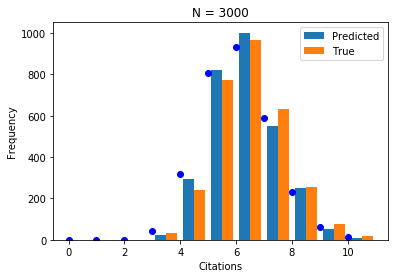

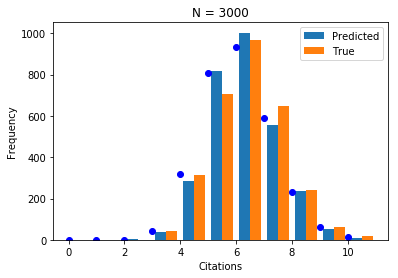

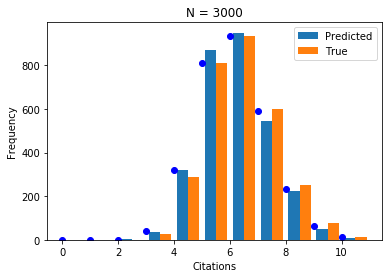

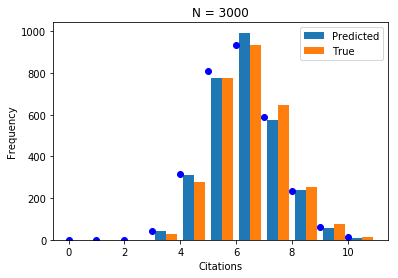

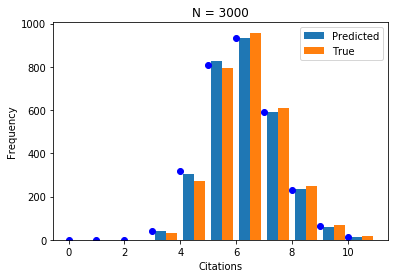

N = 3000, n = 1000, c = 15, a = 2 and m = 50


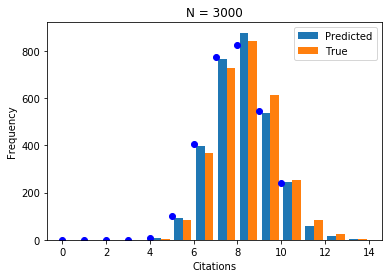

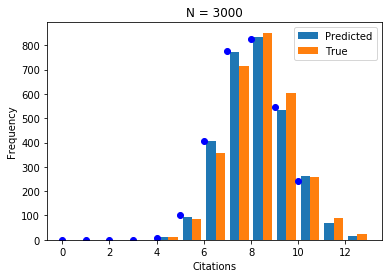

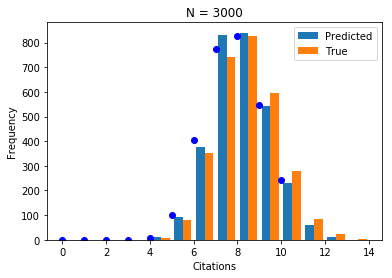

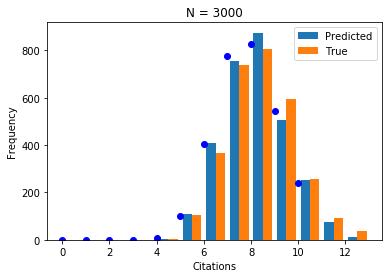

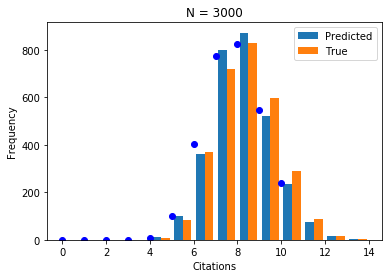

N = 3000, n = 1000, c = 15, a = 3 and m = 50


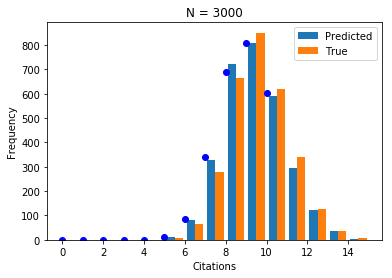

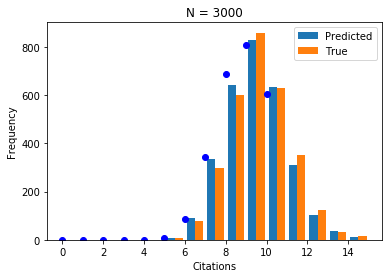

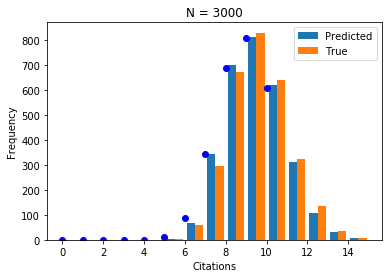

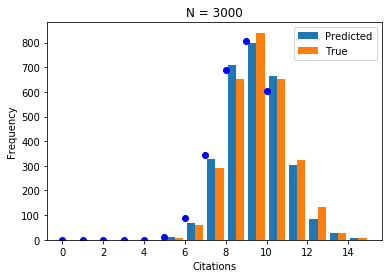

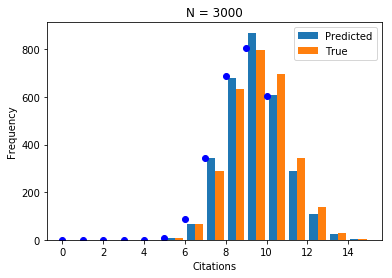

N = 3000, n = 3000, c = 3, a = 1 and m = 50


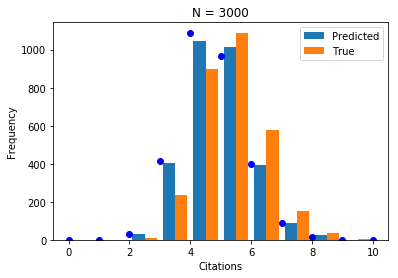

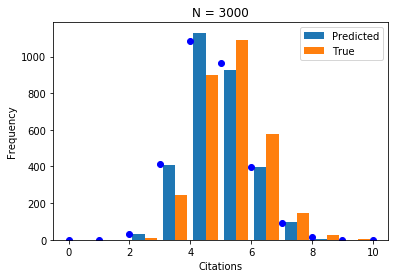

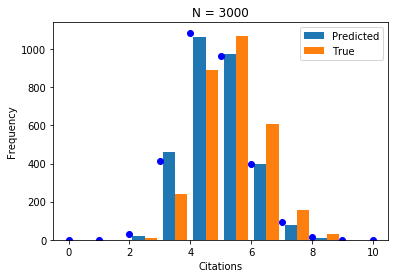

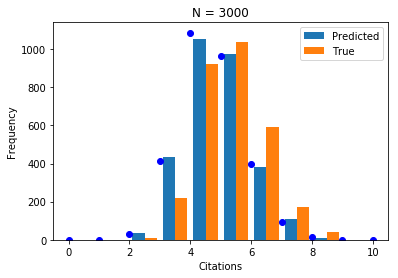

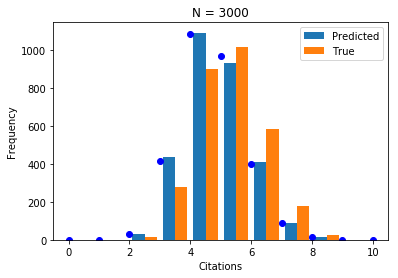

N = 3000, n = 3000, c = 3, a = 2 and m = 50


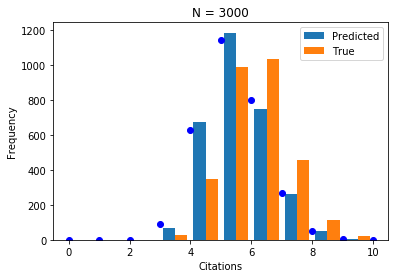

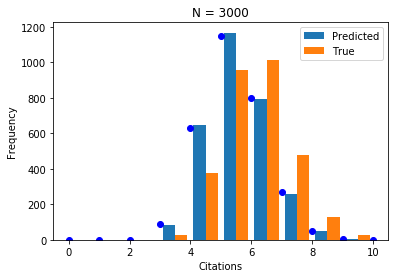

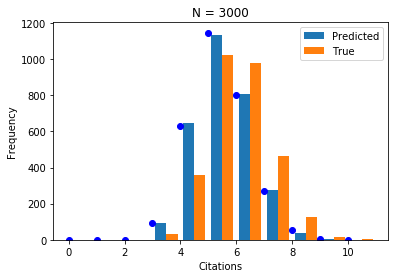

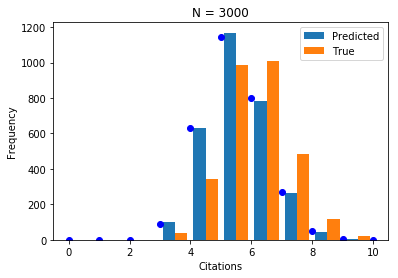

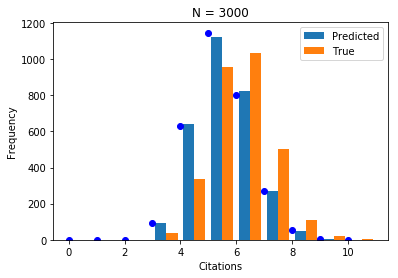

N = 3000, n = 3000, c = 3, a = 3 and m = 50


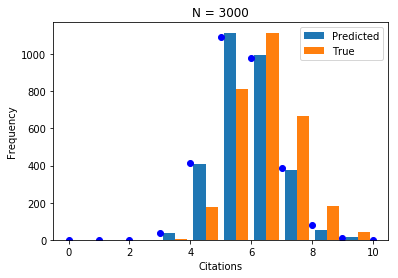

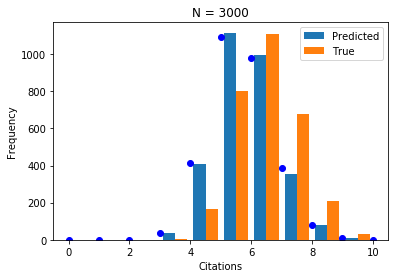

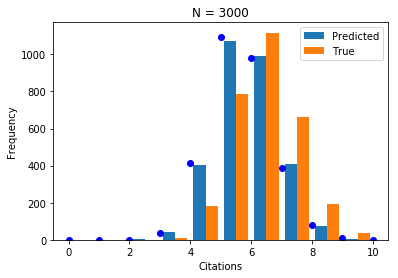

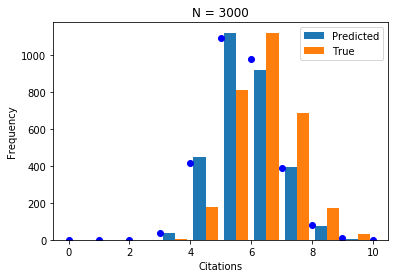

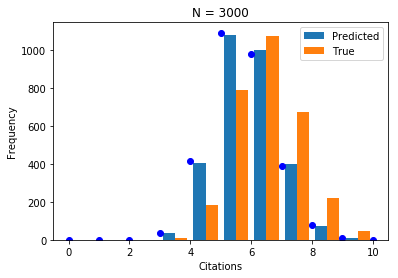

N = 3000, n = 3000, c = 5, a = 1 and m = 50


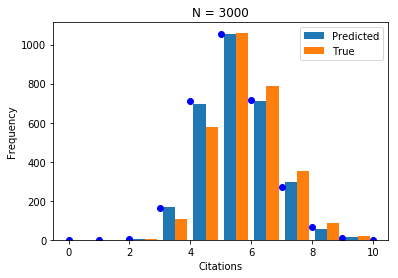

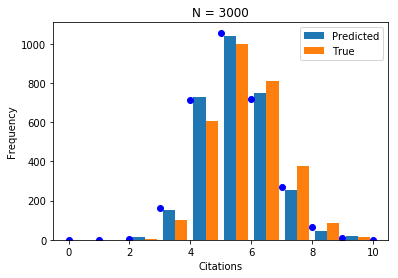

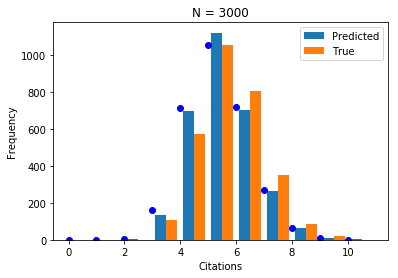

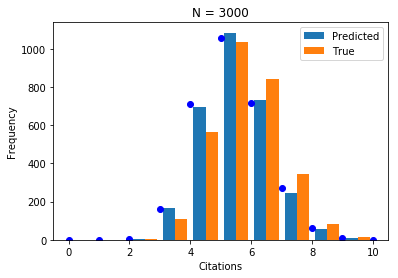

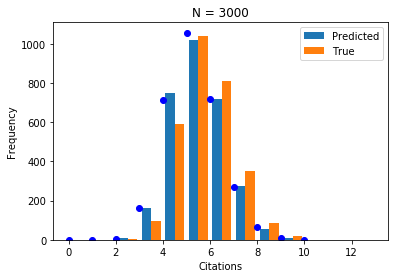

N = 3000, n = 3000, c = 5, a = 2 and m = 50


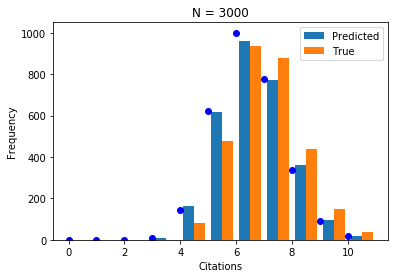

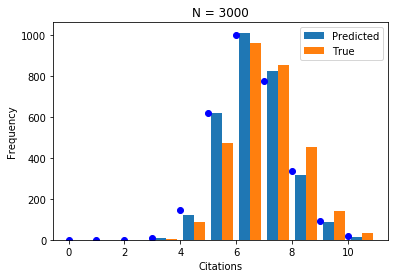

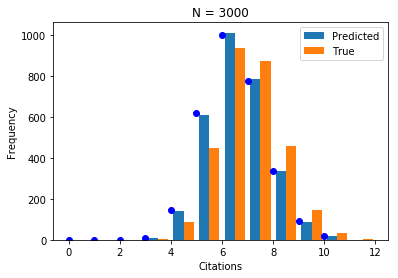

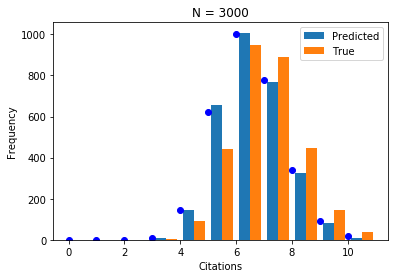

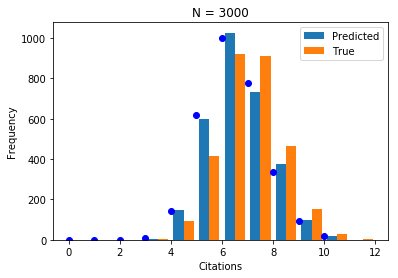

N = 3000, n = 3000, c = 5, a = 3 and m = 50


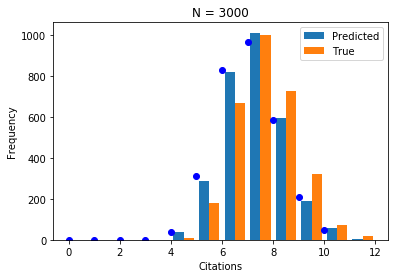

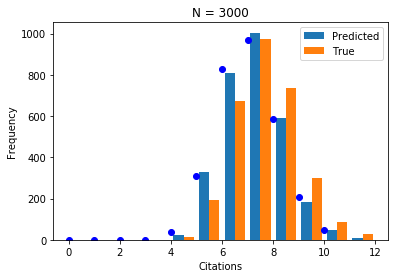

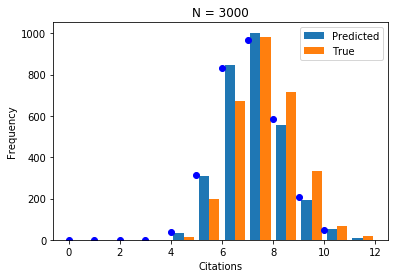

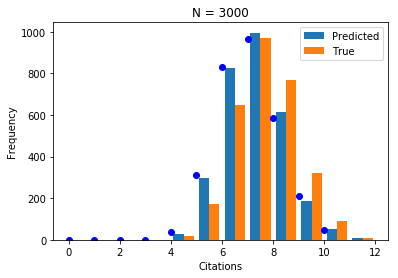

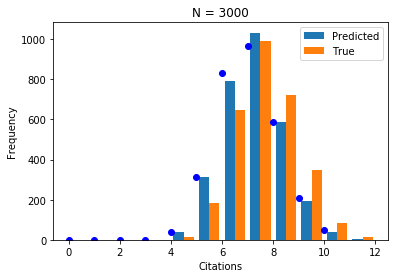

N = 3000, n = 3000, c = 10, a = 1 and m = 50


In [ ]:
m = 50
for N in [1000, 3000, 5000, 10000]:
    for n in [1000, 3000, 5000]:
        for c in [3, 5, 10, 15]:
            for a in [1, 2, 3]:
                print("N = {}, n = {}, c = {}, a = {} and m = {}".format(N, n, c, a, m))
                for trials in range(5):
                    histogram2(N, c, a, n, p, m, True)

N = 1000, n = 1000, c = 10, a = 2 and m = 50


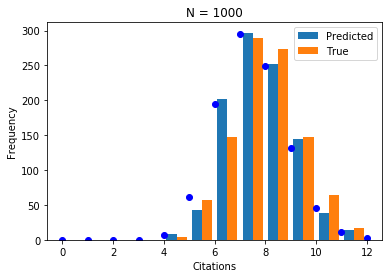

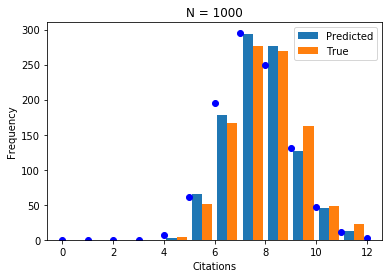

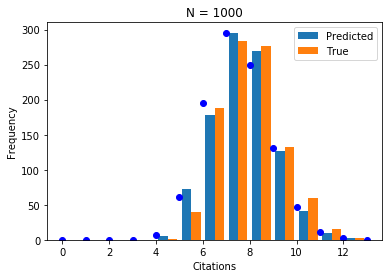

N = 1000, n = 1000, c = 10, a = 3 and m = 50


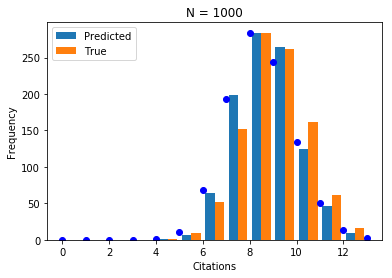

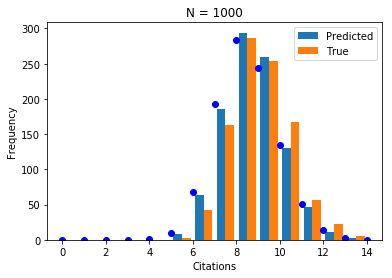

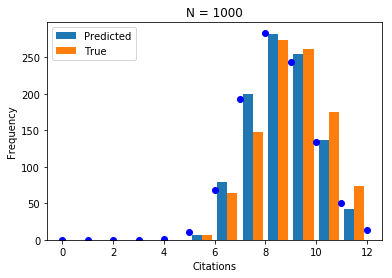

N = 1000, n = 1000, c = 10, a = 5 and m = 50


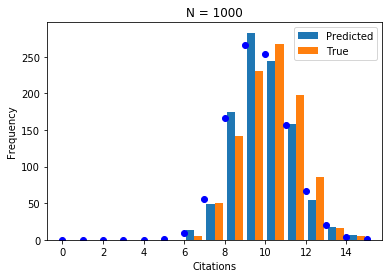

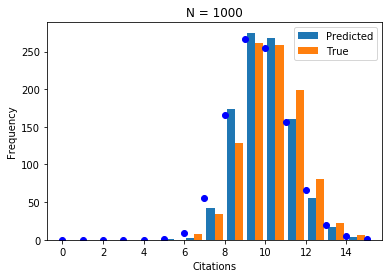

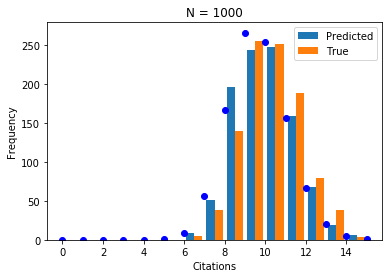

N = 1000, n = 1000, c = 15, a = 2 and m = 50


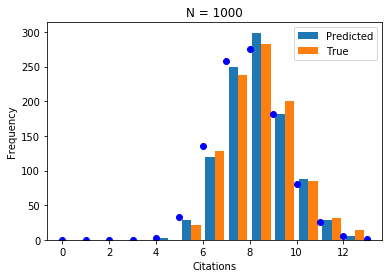

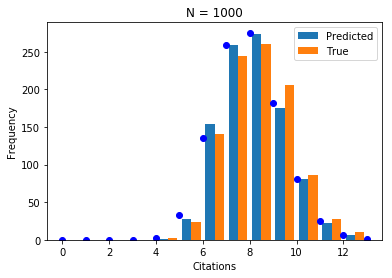

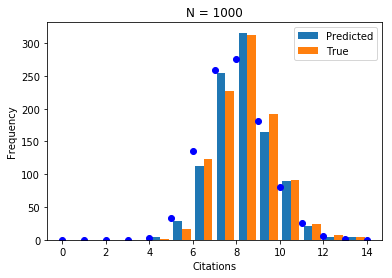

N = 1000, n = 1000, c = 15, a = 3 and m = 50


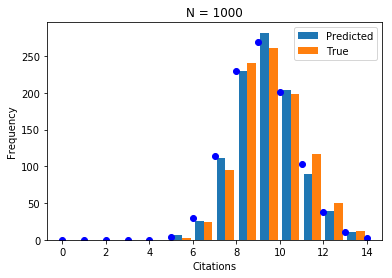

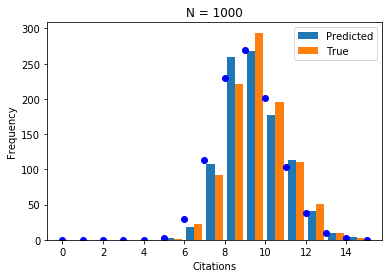

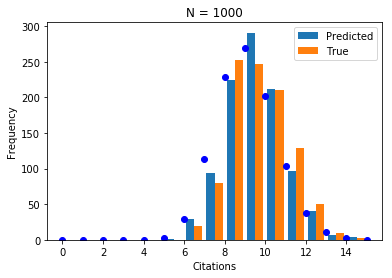

N = 1000, n = 1000, c = 15, a = 5 and m = 50


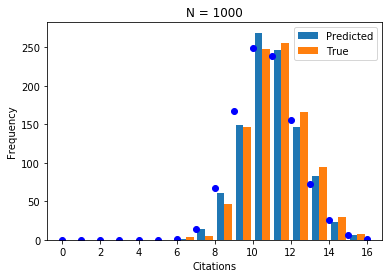

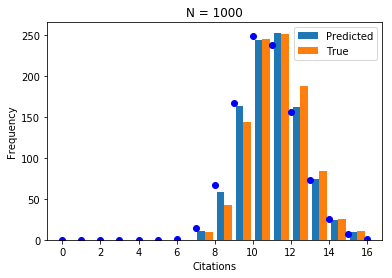

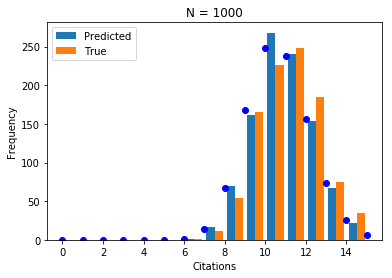

N = 1000, n = 1000, c = 20, a = 2 and m = 50


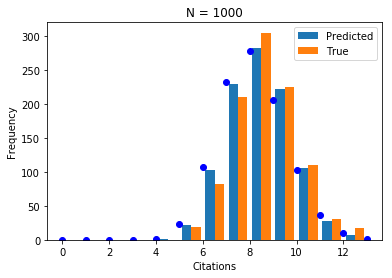

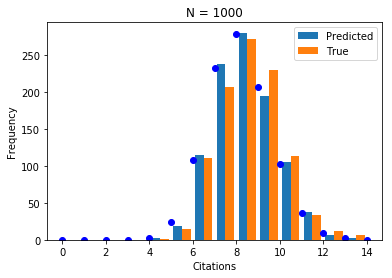

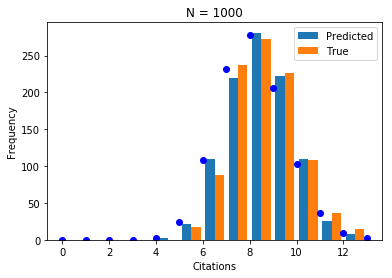

N = 1000, n = 1000, c = 20, a = 3 and m = 50


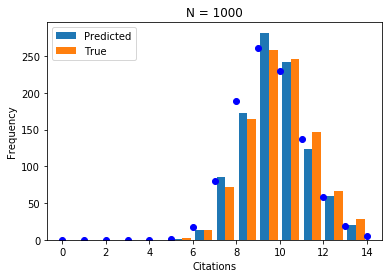

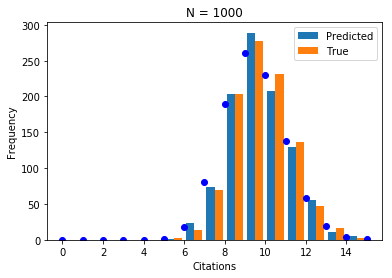

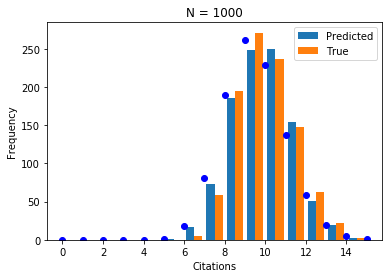

N = 1000, n = 1000, c = 20, a = 5 and m = 50


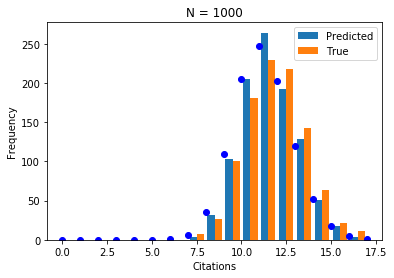

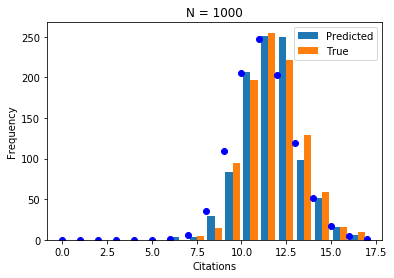

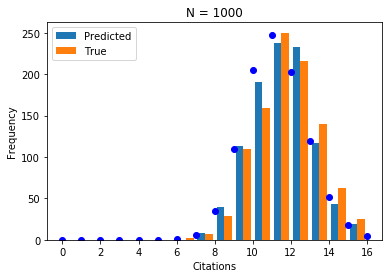

N = 1000, n = 3000, c = 10, a = 2 and m = 50


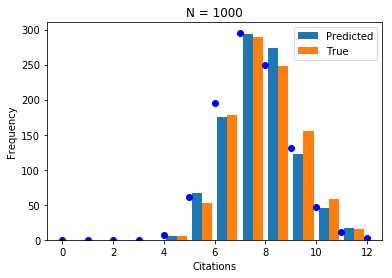

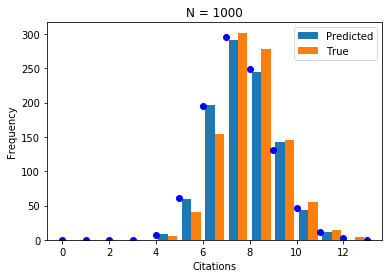

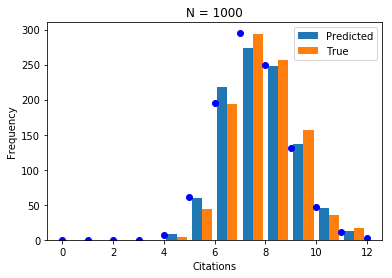

N = 1000, n = 3000, c = 10, a = 3 and m = 50


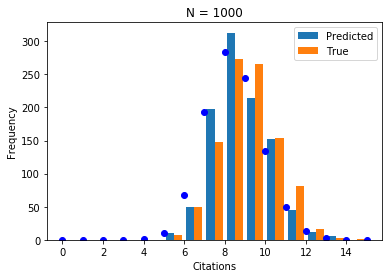

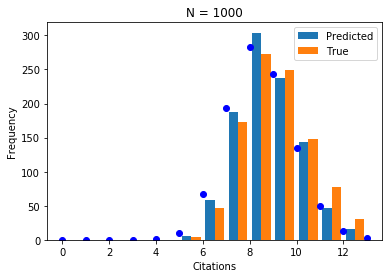

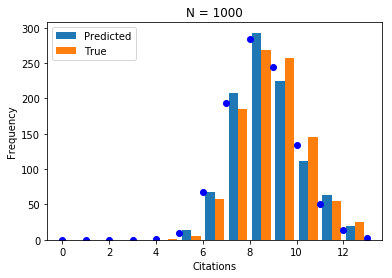

N = 1000, n = 3000, c = 10, a = 5 and m = 50


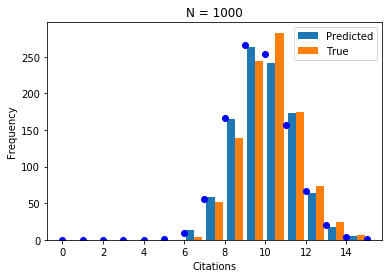

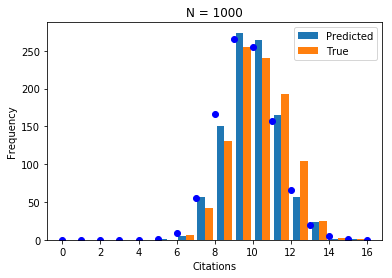

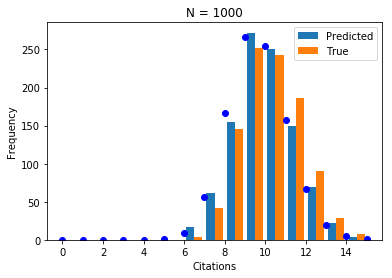

N = 1000, n = 3000, c = 15, a = 2 and m = 50


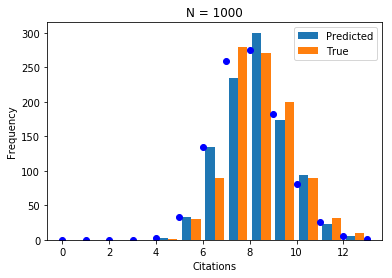

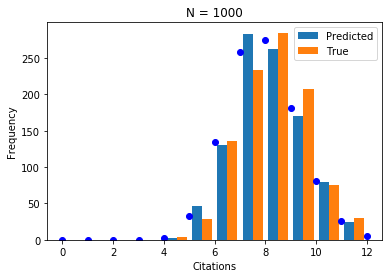

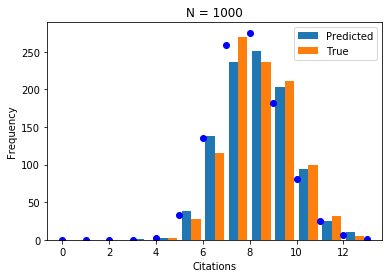

N = 1000, n = 3000, c = 15, a = 3 and m = 50


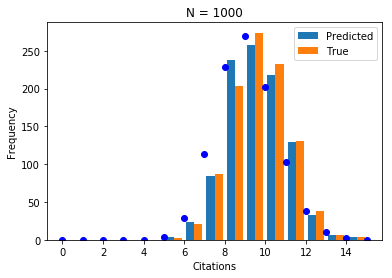

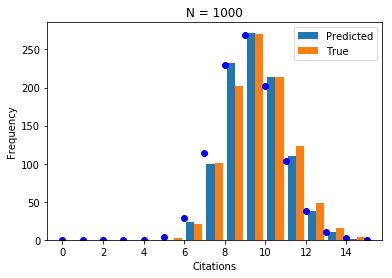

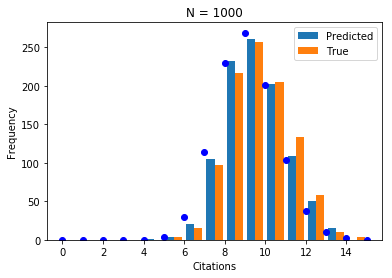

N = 1000, n = 3000, c = 15, a = 5 and m = 50


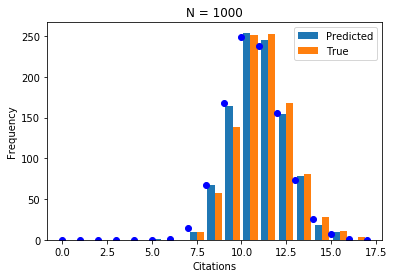

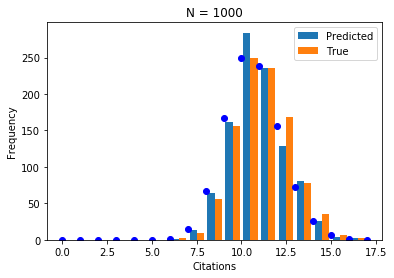

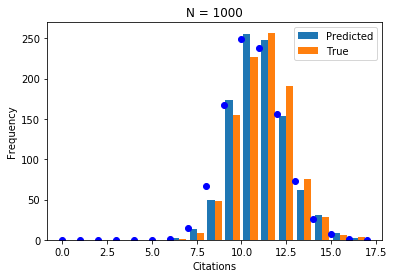

N = 1000, n = 3000, c = 20, a = 2 and m = 50


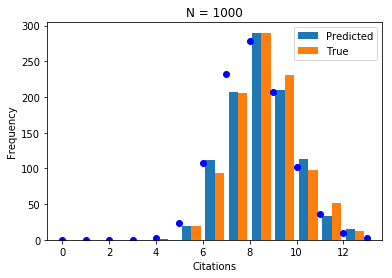

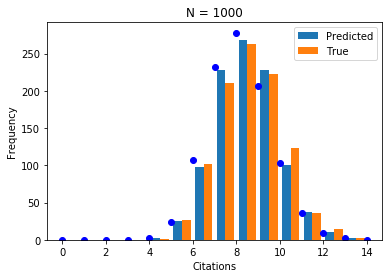

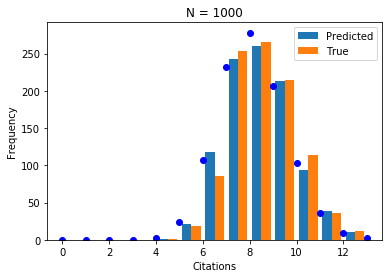

N = 1000, n = 3000, c = 20, a = 3 and m = 50


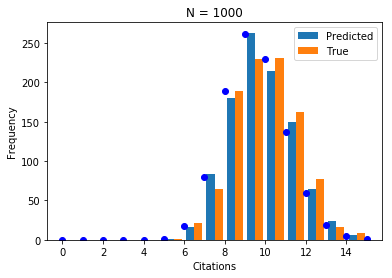

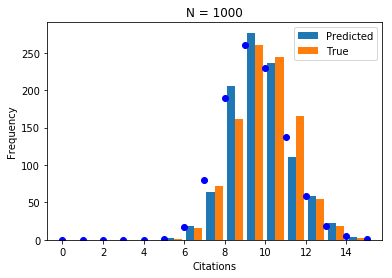

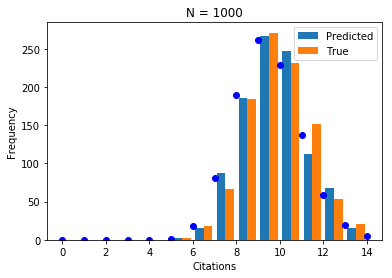

N = 1000, n = 3000, c = 20, a = 5 and m = 50


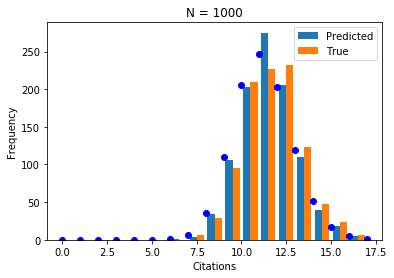

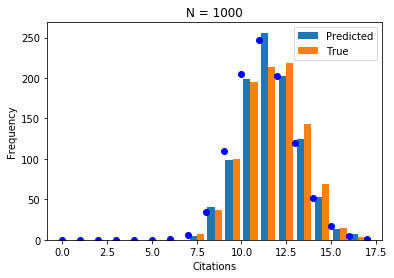

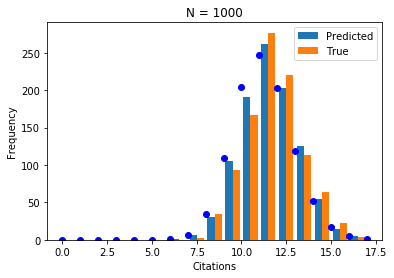

N = 1000, n = 5000, c = 10, a = 2 and m = 50


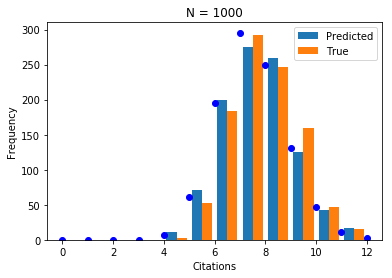

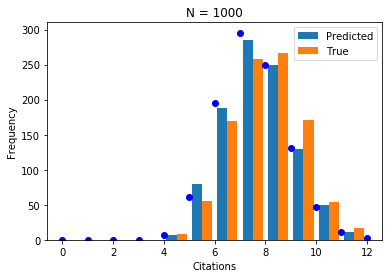

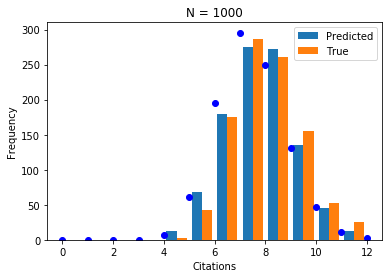

N = 1000, n = 5000, c = 10, a = 3 and m = 50


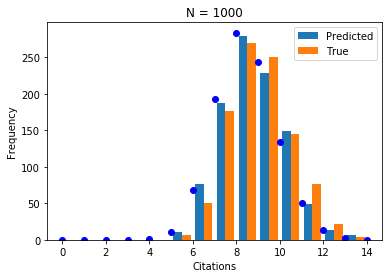

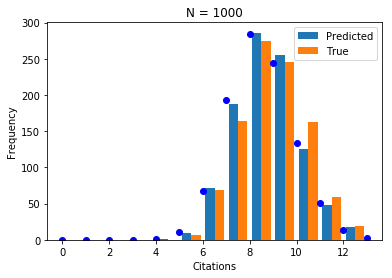

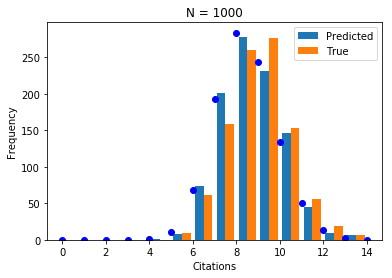

N = 1000, n = 5000, c = 10, a = 5 and m = 50


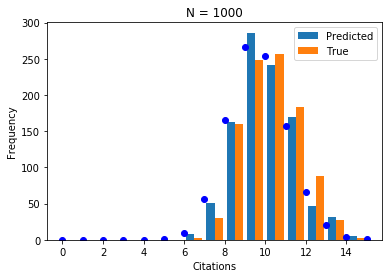

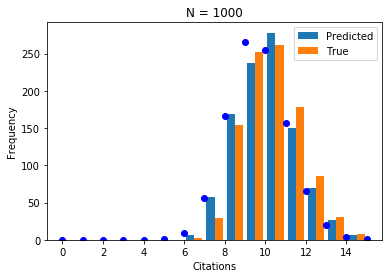

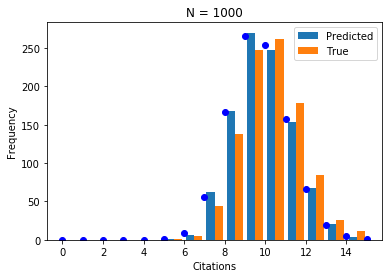

N = 1000, n = 5000, c = 15, a = 2 and m = 50


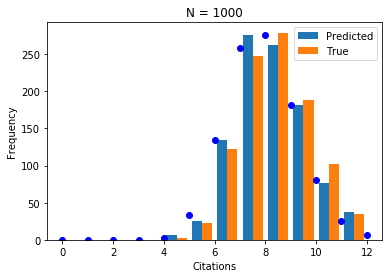

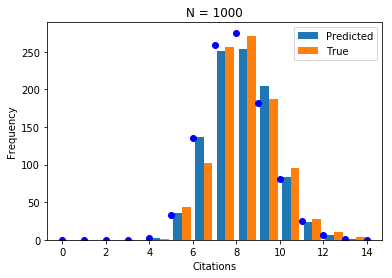

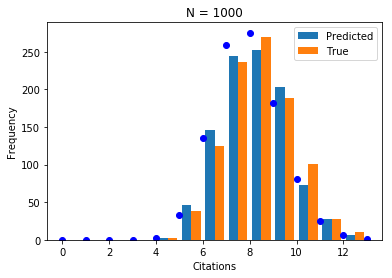

N = 1000, n = 5000, c = 15, a = 3 and m = 50


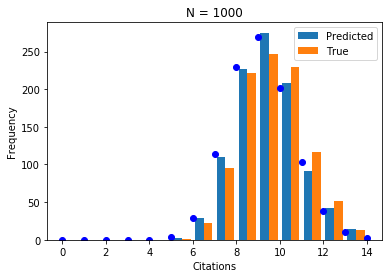

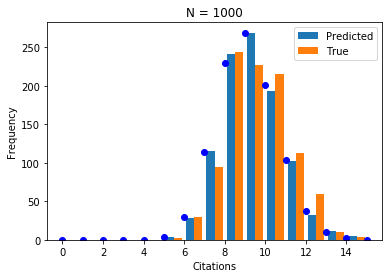

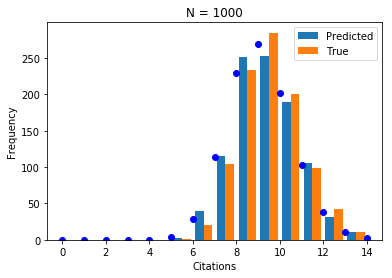

N = 1000, n = 5000, c = 15, a = 5 and m = 50


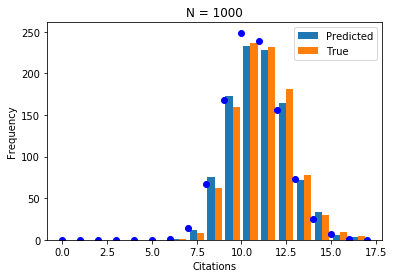

KeyboardInterrupt: 

In [34]:
m = 50
N = 1000
for n in [1000, 3000, 5000]:
    for c in [10, 15, 20]:
        for a in [2, 3, 5]:
            print("N = {}, n = {}, c = {}, a = {} and m = {}".format(N, n, c, a, m))
            for trials in range(3):
                histogram2(N, c, a, n, p, m, True)

In [61]:
def newNetworkMethod_withDist(c, a, n, dist, n_trials):
    samplingList = []
    paperList = []
    prob = c/float(c+a)
    network = [0] * n
    for i in range(1, n+1):
        if i == 1:
            paperList.append(i)
        else:
            tempList = []
            if dist == 'binomial':
                c1 = np.random.binomial(n_trials, c/float(n_trials))
                prob = c1/float(c1+a)
            elif dist == 'poisson':
                c1 = np.random.poisson(c)
                prob = c1/float(c1+a)
            elif dist == 'uniform':
                c1 = np.random.randint(1,2*c+1) 
                prob = c1/float(c1+a)
            elif dist == 'geometric':
                c1 = np.random.geometric(1/float(c))
                prob = c1/float(c1+a)
            else:
                c1 = c
            for j in range(c1):
                if samplingList:
                    if random.uniform(0,1) <= prob:
                        s = random.choice(samplingList)
                        network[s-1] += 1
                        tempList.append(s)
                        
                    else:
                        k = random.choice(paperList)
                        network[k-1] += 1
                        tempList.append(k)
                else:
                    k = random.choice(paperList)
                    network[k-1] += 1
                    tempList.append(k)
            samplingList.extend(tempList)
            paperList.append(i)
    return network

In [62]:
def plotNetworkNew_NM(aNetwork, randomList, colored): #plots
    length = len(aNetwork)
    xAxis  = range(1, length+1)

    for i in randomList:
        plt.plot(xAxis[i-1:], aNetwork[i-1][i-1:], color = colored)

In [63]:
def generateAvg_NM(c, a, n, distribution, n_trials, num, paperNum):
    networkList =[]
    if distribution:
        for i in range(0, num):
            networkList.append(newNetworkMethod(c, a, n))
    else:
        for i in range(0, num):
            networkList.append(newNetworkMethod_withDist(c, a, n, distribution, n_trials))
    for i in range(0, num):
        plotNetworkNew_NM(networkList[i], [paperNum], 'red')


    avgNodeList = []
    
    m = n
    for i in range(0, n):
        avgNodeList = []
        x = 0
        for k in range(0, num):
            #print networkList[k][i].inDegList[j]
            if j == 0:
                x += networkList[k][i]
            else:
                x += (networkList[k][i]-networkList[k][i-1])
            
            y = x/float(num)
            #print y
            avgNodeList.append(y)
            #print avgNodeList[i].inDegree
            avgNodeList[i].listAdd()
    plotNetworkNew_NM(avgNodeList, [paperNum], 'blue')
    red_patch = mpatches.Patch(color='red', label='Simulated Paper Network')
    blue_patch = mpatches.Patch(color='blue', label='Average of Simulated Data')
    plt.legend(handles=[red_patch, blue_patch])
    plt.xlabel('Paper Number')
    plt.ylabel('Citations')
    plt.title('Paper %i' % paperNum)
    plt.show()
    return avgNodeList

In [64]:
def plotBoth_NM(aNetwork, bNetwork, ithPos, randomList, tru): #takes array value as well for EV
    if tru:
        i = randomList[ithPos-1]
    else:
        i = ithPos
    length = len(aNetwork)
    xAxis = range(1, length+1)
    red_patch = mpatches.Patch(color='red', label='Expected Value')
    blue_patch = mpatches.Patch(color='blue', label='Average of Simulated Data with 100 Networks')
    
    plt.plot(xAxis[i-1:], aNetwork[i-1], color = 'blue')
    plt.plot(xAxis[i-1:], bNetwork[i-1], color = 'red')
    plt.xlabel('Paper Number')
    plt.ylabel('Citations')
    plt.title('%ith Paper by the Author' % ithPos)
    plt.legend(handles=[red_patch, blue_patch])
    
    plt.show()

In [65]:
def histogram3(N, c, a, n, p, m, with_hDist, distribution, n_trials):
    hIndexG = []
    hIndexNet = []
    for i in range(1,N+1):
        #randomList = generateRandList(n, p)
        randomList = generateListUniform(n, m)
        randomList.sort()
        aNetwork = newNetworkMethod_withDist(c, a, n, distribution, n_trials)
        y = theoreticalG(c, a , n, randomList)
        hIndexG.append(G_hIndex_forTimet(y, randomList))
        hIndexNet.append(network_hIndex_forNewMethod(aNetwork, randomList, n))

    b = max(max(hIndexG), max(hIndexNet))+1
    bins = range(b)
    
    print(distribution)
        #hDist_fromErlang(N, m, c, a)
    #plt.hist(hIndexNet, bins, color = 'blue')
    fig, ax = plt.subplots()
    ax.hist([hIndexG, hIndexNet], bins, label = ['Predicted', 'True'])
    if with_hDist:
        distribution = hDist_fromBeta(N, m, c, a)
        ax.plot(np.multiply(N,distribution)[:b], 'bo')
    ax.set_xlabel('Citations')
    ax.set_ylabel('Frequency')
    ax.set_title('N = %i' % N)
    ax.legend()
    plt.show()
    #interactive(False)
    #raw_input()

binomial


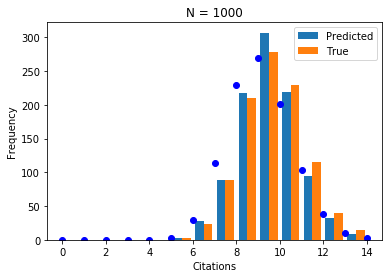

binomial


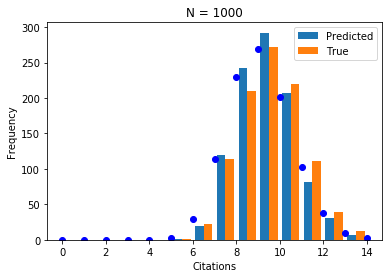

binomial


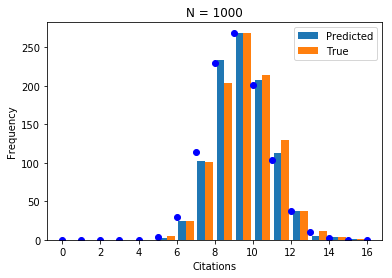

poisson


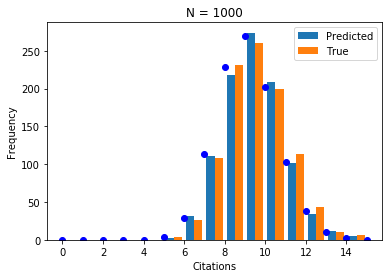

poisson


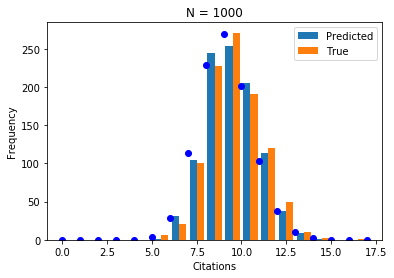

poisson


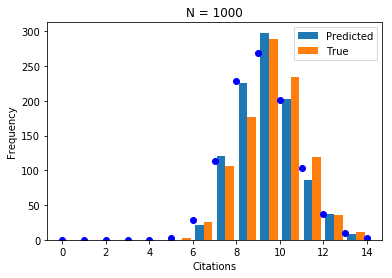

uniform


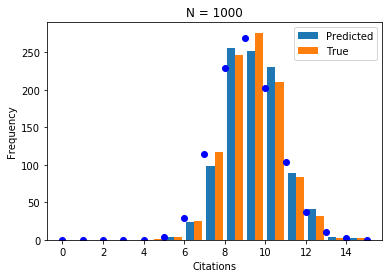

uniform


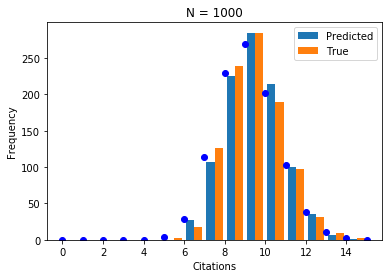

uniform


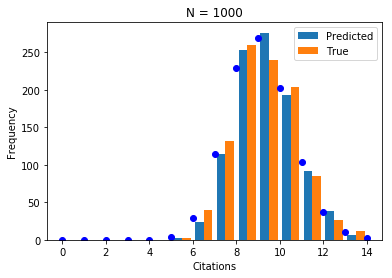

geometric


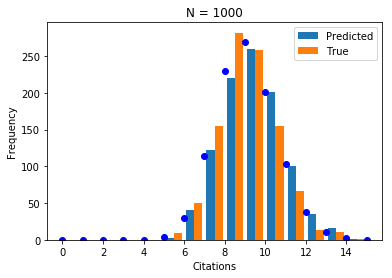

geometric


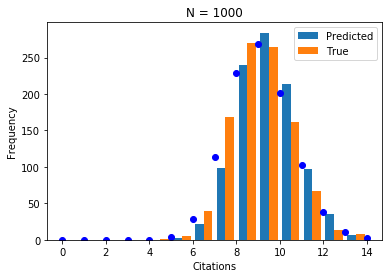

geometric


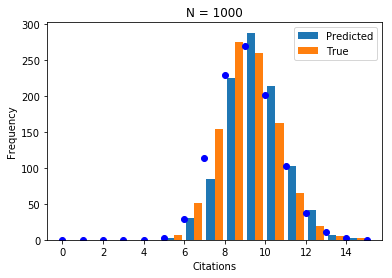

In [66]:
c = 15
n = 1000
a = 3
p = .05
N = 1000 
m = 50

for i in ['binomial', 'poisson', 'uniform', 'geometric']: 
    for trials in range(3):
        histogram3(N, c, a, n, p, m, True, i, c*5)